In [6]:
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#  Copyright (c) 2020. Reda Bouadjenek, Deakin University                      +
#     Email:  reda.bouadjenek@deakin.edu.au                                    +
#                                                                              +
#  Licensed under the Apache License, Version 2.0 (the "License");             +
#   you may not use this file except in compliance with the License.           +
#    You may obtain a copy of the License at:                                  +
#                                                                              +
#                 http://www.apache.org/licenses/LICENSE-2.0                   +
#                                                                              +
#    Unless required by applicable law or agreed to in writing, software       +
#    distributed under the License is distributed on an "AS IS" BASIS,         +
#    WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  +
#    See the License for the specific language governing permissions and       +
#    limitations under the License.                                            +
#                                                                              +
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
from gurobipy import *
import matplotlib.pyplot as plt
import json
from tqdm import tqdm
import numpy as np
import time
from scipy import stats
import pandas as pd
import itertools,operator


# Optimizing <i>expected</i> F1-Score using Linear Programming

## Motivation
We will argue that (expected) F1-Score of a substring is the only standard criteria that balances all of substring desiderata and is hence objective we should optimize.

To proceed with the formal derivation, we adopt the Boolean relevance framework in information retrieval and thus assume that a token $j$ has a ground truth relevance assessment $B(j)$ available at <i>evaluation time</i>.


Because selecting a substring implies a Boolean selection model (a substring either contains or do not contain tokens) and we have a probabilistic estimate of relevance $P(j)$ for each token, we propose to evaluate
<i>expected</i> variants of standard precision, recall, and F1-score of these substrings.


However, as standard for both precision and recall, we note that precision and recall alone can be trivially optimized by undesired solutions.  That is, the substring that selects all tokens would trivially maximize (expected) recall.  Similarly, the substring that selects the highest probability singleton token would maximize expected precision.  <i>This leaves expected F1-score as the only of these three objectives commonly used in Boolean information retrieval that does not have an undesired solution</i>.


## Deriving Expected F1-Score (EF1)


To formally define expected F1-Score, we first begin with definitions of expected precision and recall.  Given a substring $S_{sub}$  of a string $S$ ($|S|=m$), the precision of $S_{sub}$ is defined as follows:
\begin{equation}
   P(S_{sub}) = \dfrac{\sum_{j \in S_{sub}} B(j)}{|S_{sub}|} = \dfrac{\sum_{j=1}^m B(j)I(j)}{\sum_{j=1}^m I(j)} 
\end{equation}

where the two variables  $I(j) \in \{0,1\}$ and $B(j) \in \{0,1\}$ are associated with each token $j$ of $S$: 

- $I(j)$ is an indicator referring to whether a token $j$ is part of $S_{sub}$ ($\textrm{true}\!=\!1$); 
- $B(j)$ is a Boolean random variable indicating the (ground truth) relevance of a tokan $j$ ($\textrm{relevant}\!=\!1$).


Given that $B(j)$ is a Boolean random variable, we can take the expectation of $P(S_{sub})$ leading to the following definition of <i>expected precision</i> $EP(S_{sub})$: 

\begin{equation}
EP(S_{sub})=\mathbb{E_{P}}\left[\dfrac{{ \sum_{j=1}^{m}}B(j)I(j)}{{ \sum_{j=1}^{m}}I(j)}\right]=\dfrac{{ \sum_{j=1}^{m}}\mathbb{E_{S}}[B(j)]I(j)}{{ \sum_{j=1}^{m}}I(j)}=\dfrac{{ \sum_{j=1}^{m}}P(j)I(j)}{{ \sum_{j=1}^{m}}I(j)}
\end{equation}

where the variable $P(j) \in [0,1]$ is the <i>probability</i> relevance of a token $j$.


Similarly the recall of a substring $R(S_{sub})$ is defined as:

\begin{equation}
   R(S_{sub}) = \dfrac{\sum_{j \in S_{sub}} B(j)}{\sum_{j \in S} B(j)} = \dfrac{\sum_{j=1}^m B(j)I(j)}{ \sum_{j=1}^m B(j)} 
\end{equation}


Taking a 1st order Taylor expansion, we have the following expectation approximation 
$\mathbb{E}(X/Y)\approx \mathbb{E}(X)/ \mathbb{E}(Y)$ for two dependent random variables $X$ and $Y$. Hence, we can now define an <i>approximated expected recall</i> as follows: 

\begin{equation}
   ER(S_{sub})=\mathbb{E_{P}}\left[\dfrac{{ \sum_{j=1}^{m}}B(j)I(j)}{\sum_{j=1}^m B(j)}\right]\approx\dfrac{{ \sum_{j=1}^{m}}\mathbb{E_{P}}[B(j)]I(j)}{{ \sum_{j=1}^{m}}\mathbb{E_{P}}[B(j)]}=\dfrac{{ \sum_{j=1}^{m}}P(j)I(j)}{{ \sum_{j=1}^{m}}P(j)}
\end{equation}


Finally, we define the <i>approximated expected F1-Scor</i> (EF1) using the <i>expected precision</i> and the <i>approximated expected recall</i> as follows: 
\begin{align}
    EF1(E)  \approx \dfrac{2\times EP\times ER}{EP+ER} = \dfrac{2\times\sum_{j=1}^m P(j)I(j)}{\sum_{j=1}^m I(j) + \sum_{j=1}^m P(j)}
    \label{eq:EF1}
\end{align}


## Fractional MILP Formulation


We begin by reformulating the <b><i>Expected</i> F1-score (EF1)</b> objective to prepare for further optimization steps by replacing the global sum of scores of all tokens with a constant $C = \sum_{j=1}^m P(j)$:
\begin{equation}
\begin{aligned}
    EF1 &= \dfrac{2\times \sum_{j=1}^m P(j)I(j)}{\sum_{j=1}^m I(j) + \sum_{j=1}^m P(j)} = \dfrac{2 \times \sum_{j=1}^m P(j)I(j)}{\sum_{j=1}^m I(j) + C}
\end{aligned}
\end{equation}





In order to obtain the substring with the obtimal <b><i>Expected</i> F1-score</b>, we define the following fractional MILP:

\begin{equation}
\begin{aligned}
& \underset{I(j)}{\text{maximize}}
& & \dfrac{\sum_{j=1}^m P(j)I(j)}{\sum_{j=1}^m I(j) + C} \\
& s.t
& & \text{# Interval selection contraints.} \\
& & & 1 <=  s <= e <= m \\
& & & I(j) =
   \begin{cases}
     1, & \text{if $(s \leqslant j \leqslant e)$}  \\
     0, & \text{otherwise}
  \end{cases}
\end{aligned} 
\end{equation}

## Transformation to a MILP

While there are no direct solvers for fractional MILPs, we can transform the former equation into a pure MILP form for which we have efficient and optimal solvers.  To do this, we use the Charnes-Cooper method and Glover linearization method with big-M constraints, where auxiliary variables $w(j)$ and $u$ are  introduced*. Here, $w(j)$ is defined as $w(j)=I(j)\times u$ with $u$ defined as follows:
\begin{equation}
u = \dfrac{1}{\sum_{j=1}^m I(j) + C}
\end{equation}

Then, the EF1 optimization problem is able to be transformed into the following MILP problem:
\begin{equation}
\begin{aligned}
& \underset{w,u,I,s,e}{\text{maximize}}
& & \sum_{j=1}^m P(j)w(j) \\
& s.t
& & \sum_{j=1}^m w(j) + uC = 1 \\
& & & w(j) \leqslant u, \quad w(j) \leqslant M\times I(j)  \\
& & & w(j) \geqslant u - M\times [1-I(j)] \\
& & & u > 0,  \quad I(j) \in \{0, 1\}, \quad w(j) \geqslant 0 \\
& & & \text{# Interval selection contraints.} \\
& & & 1 <=  s <= e <= m \\
& & & I(j) =
   \begin{cases}
     1, & \text{if $(s \leqslant j \leqslant e)$}  \\
     0, & \text{otherwise}
  \end{cases} \label{eq:cons1} 
\end{aligned}
\end{equation}

*https://optimization.mccormick.northwestern.edu/index.php/Mixed-integer_linear_fractional_programming_(MILFP)

## Algorithm implementation

In [2]:
def select_LP_optimal_subsequence(probabilities):
    """
    This function optimizes the expected f1-score to choose the optimal subsequence 
    of probabilities.
    :param probabilities: the sequence of probabilities.
    :return: the start index and the end index of the optimal subsequence.
    """
    C = sum(probabilities)
    M = 1e4  # Value for Big M.
    dict_probabilities = dict({j: probabilities[j] for j in range(len(probabilities))})
    ###################
    # Define the model.
    ###################
    model = Model('EF1-Score')
    model.setParam( 'OutputFlag', False) # make Gurobi silent.
    # element variable
    w = model.addVars(dict_probabilities.keys(), lb=0.0, ub=1.0, vtype='C', name='w')
    I = model.addVars(dict_probabilities.keys(), lb=0.0, ub=1.0, vtype='B', name='I')
    u = model.addVar(lb=0, vtype='C', name='u')

    # Index variables
    Is = model.addVars(dict_probabilities.keys(), vtype='B', name='Is')
    Ie = model.addVars(dict_probabilities.keys(), vtype='B', name='Ie')

    s = model.addVar(lb=0, ub=len(dict_probabilities) - 1, vtype='I', name='s')
    e = model.addVar(lb=0, ub=len(dict_probabilities) - 1, vtype='I', name='e')

    # Objective function
    model.setObjective(w.prod(dict_probabilities), GRB.MAXIMIZE)

    # Constraints

    model.addConstr(quicksum(w[j] for j in range(len(dict_probabilities))) + u * C == 1.0, 'sum(w)+uC=1')
    model.addConstr(s <= e, 's<=e')
    for j in dict_probabilities:
        model.addConstr(w[j] <= u, f"w[{j}]<=u")
        model.addConstr(w[j] <= M * I[j], f"w[{j}]<=M*I({j})")
        model.addConstr(w[j] >= u - M * (1 - I[j]), f"w[{j}]>=u-M*[1-I({j})]")
        model.addConstr(w[j] >= 0.0, f"w[{j}]>=0.0")

        # Interval selection constraints
        model.addGenConstrAnd(I[j], [Is[j], Ie[j]], f"selection_constraint-{j}")

        model.addGenConstrIndicator(Is[j], True, s <= j)
        model.addGenConstrIndicator(Ie[j], True, e >= j)

        model.addGenConstrIndicator(Is[j], False, s >= j + 1)
        model.addGenConstrIndicator(Ie[j], False, e <= j - 1)

    model.optimize()
    # model.write("out.lp")
    optimal_value = 2 * model.getObjective().getValue() # optimal ef1 score
    return int(round(s.X)), int(round(e.X)), optimal_value


## Example

In [3]:
text = ['A', 'Research', 'Fellow', 'position', 'is', 'available', 'in', 'Machine', 'Learning',
        'at', 'the', 'School', 'of', 'Computer', 'Science', 'of',
        'the', 'University', 'of', 'Birmingham', 'UK', '.',
        'The', 'appointment', 'is', 'in', 'connection', 'with', 'the', 'EPSRC', 'Fellowship', '.'
        ]

# question: in which university is the research position available?


probabilities = [0.5, 0.001, 0.001, 0.8, 0.005, 0.01, 0.005, 0.01, 0.005,
                 0.001, 0.91, 0.5, 0.01, 0.099, 0.099, 0.05,
                 0.0001, 0.5, 0.9, 0.99, 0.8, 0.7,
                 0.03, 0.1, 0.01, 0.001, 0.1, 0.01, 0.001, 0.1, 0.99, 0.0099]


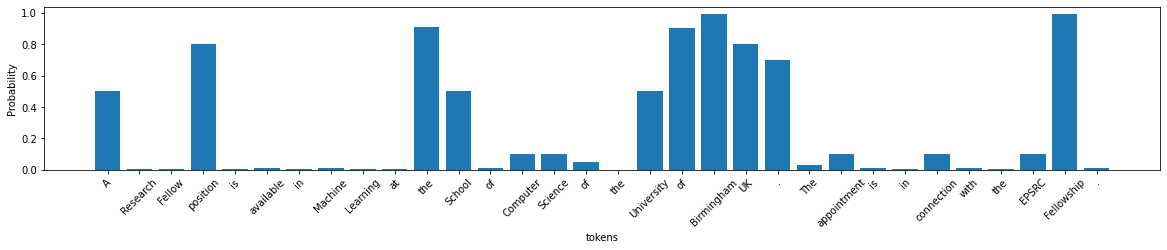

In [4]:
x = list(j for j in range(len(probabilities)))
plt.figure(figsize=(20, 3))
plt.bar(x, probabilities)  # A bar chart
plt.xlabel('tokens')
plt.ylabel('Probability')
plt.xticks(x, text, rotation='45')
plt.show()


In [5]:
s,e,_ = select_LP_optimal_subsequence(probabilities)

Using license file /Users/rbouadjenek/gurobi.lic
Academic license - for non-commercial use only


In [6]:
for i in range(s,e+1):
    print(text[i], end =" ")

University of Birmingham UK . 

# Test

In [1]:
import os
import re
import json
import string
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer, TFBertModel, BertConfig
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score
from tensorflow.python.ops import math_ops
from tensorflow.python.keras import backend as K
from keras.utils.vis_utils import plot_model
from keras.metrics import binary_accuracy
from transformers import AlbertTokenizer, AlbertModel
import seaborn as sns
from tqdm import tqdm
import random
from transformers import TFAutoModel


max_len = 300



In [2]:
# Save the slow pretrained tokenizer
slow_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
save_path = "bert_base_uncased/"


# slow_tokenizer = BertTokenizer.from_pretrained("bert-large-uncased")
# save_path = "bert_large_uncased/"

if not os.path.exists(save_path):
    os.makedirs(save_path)
slow_tokenizer.save_pretrained(save_path)

# Load the fast tokenizer from saved file
tokenizer = BertWordPieceTokenizer("bert_base_uncased/vocab.txt", lowercase=True)

# tokenizer = BertWordPieceTokenizer("bert_large_uncased/vocab.txt", lowercase=True)

tokenized_context = tokenizer.encode('Hello, my dog is cute. Where is it?')



# print(tokenized_context.ids)
# print(tokenizer.decode(tokenized_context.ids, skip_special_tokens=False))

In [3]:
# train_data_url = "https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json"
train_data_url = "https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v1.1.json"
train_path = keras.utils.get_file("train.json", train_data_url)

# test_data_url = "https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json"
test_data_url = "https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v1.1.json"
test_path = keras.utils.get_file("eval.json", test_data_url)



with open(train_path) as f:
    raw_train_data = json.load(f)
topics = raw_train_data['data']
random.Random(1).shuffle(topics)

i = int(len(raw_train_data['data'])*0.95)
raw_train_data = {'data':topics[:i]}
# raw_train_data = {'data':topics[:1]}

raw_eval_data = {'data':topics[i:]}
# raw_eval_data = {'data':topics[441:]}



with open(test_path) as json_file:
    raw_test_data = json.load(json_file)

print(len(raw_train_data['data']))
print(len(raw_eval_data['data']))
print(len(raw_test_data['data']))



419
23
48


In [4]:
# check the code here... factorize it!
train_context_size_dist = []
train_all_answers_dist = []
for item in raw_train_data["data"]:
  for para in item["paragraphs"]:
    context = para["context"]
    tokenized_context = tokenizer.encode(context)    
    for qa in para["qas"]:
      question = qa["question"]
      tokenized_question = tokenizer.encode(question)          
      all_answers = [_["text"] for _ in qa["answers"]]
      train_context_size_dist.append(len(tokenized_question.ids) + len(tokenized_context.ids) - 1)
      train_all_answers_dist.append(len(qa["answers"]))


eval_context_size_dist = []
eval_all_answers_dist = []
for item in raw_eval_data["data"]:
  for para in item["paragraphs"]:
    context = para["context"]
    tokenized_context = tokenizer.encode(context)    
    for qa in para["qas"]:
      question = qa["question"]
      tokenized_question = tokenizer.encode(question)          
      all_answers = [_["text"] for _ in qa["answers"]]
      eval_context_size_dist.append(len(tokenized_question.ids) + len(tokenized_context.ids) - 1)
      eval_all_answers_dist.append(len(qa["answers"]))

test_context_size_dist = []
test_all_answers_dist = []
for item in raw_test_data["data"]:
  for para in item["paragraphs"]:
    context = para["context"]
    tokenized_context = tokenizer.encode(context)    
    for qa in para["qas"]:
      question = qa["question"]
      tokenized_question = tokenizer.encode(question)          
      all_answers = [_["text"] for _ in qa["answers"]]
      for answer in qa["answers"]:
        start = answer["answer_start"]
        end = start+len(answer["text"])
        range(start,end+1)
      start_char_idx = qa["answers"][0]["answer_start"]
      test_context_size_dist.append(len(tokenized_question.ids) + len(tokenized_context.ids) - 1)
      test_all_answers_dist.append(len(qa["answers"]))



In [7]:

df_test_all_answers_dist = pd.DataFrame(columns=['x','y'])
list_test_all_answers_dist = list(zip(test_all_answers_dist,test_all_answers_dist))
df_test_all_answers_dist = df_test_all_answers_dist.append(pd.DataFrame(list_test_all_answers_dist, columns=['x','y']),ignore_index=True)
df_test_all_answers_dist


,x,y
0,3,3
1,3,3
2,3,3
3,3,3
4,3,3
...,...,...
10565,5,5
10566,5,5
10567,5,5
10568,5,5


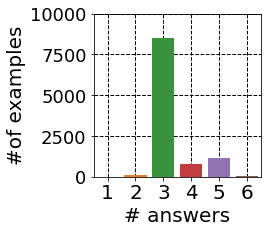

In [16]:
# from numpy import count
plt.figure(figsize=(3,3))

tips = sns.load_dataset("tips")
ax = sns.barplot(x="x", y="y", data=df_test_all_answers_dist, estimator=len, ci=None)

ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)
plt.xlabel("# answers")
plt.ylabel("#of examples")
# plt.title("Box plot of #candidates per cycle and system")
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 20,
          'ytick.labelsize': 18,
          'axes.titlepad': 25,
          'font.size': 24}
plt.rcParams.update(params)
plt.ylim(0, 10000)
plt.savefig('plots/dist_answers_in_examples_SQuAD1.1.eps', bbox_inches = 'tight')
plt.show()



In [13]:
class SquadExample:
    def __init__(self, question, context, start_char_idx, answer_text, all_answers):
        self.question = question
        self.context = context
        self.start_char_idx = start_char_idx
        self.answer_text = answer_text
        self.all_answers = all_answers
        self.skip = False

    def preprocess(self):
        context = self.context
        question = self.question
        answer_text = self.answer_text
        start_char_idx = self.start_char_idx

        # Clean context, answer and question
        context = " ".join(str(context).split())
        question = " ".join(str(question).split())
        answer = " ".join(str(answer_text).split())

        # Find end character index of answer in context
        end_char_idx = start_char_idx + len(answer)
        if end_char_idx >= len(context):
            self.skip = True
            return

        # Mark the character indexes in context that are in answer
        is_char_in_ans = [0] * len(context)
        for idx in range(start_char_idx, end_char_idx):
            is_char_in_ans[idx] = 1

        # Tokenize context (paragraph)
        tokenized_context = tokenizer.encode(context)

        # Find tokens that were created from answer characters
        ans_token_idx = []
        for idx, (start, end) in enumerate(tokenized_context.offsets):
            if sum(is_char_in_ans[start:end]) > 0:
                ans_token_idx.append(idx)

        if len(ans_token_idx) == 0:
            self.skip = True
            return

        
        

        # Tokenize question
        tokenized_question = tokenizer.encode(question)
        
        # Extract labels
        labels = np.zeros(len(tokenized_context.ids)).tolist()
        for i in ans_token_idx:
            labels[i] = 1
        
        labels = np.zeros(len(tokenized_question.ids)-1).tolist() + labels
        
        ## padding labels
        if max_len - len(labels) > 0:
            labels = labels + np.zeros(max_len - len(labels)).tolist()
            
        # for i in range(len(labels)):
        #     v = labels[i]
        #     labels[i] = np.array([v])
            
            
        ## output mask
        output_mask = np.ones(len(tokenized_context.ids)-1).tolist()
        output_mask = np.zeros(len(tokenized_question.ids)).tolist() + output_mask
        if max_len - len(output_mask) > 0:
            output_mask = output_mask + np.zeros(max_len - len(output_mask)).tolist()
        
        # Find start and end token index for tokens from answer
        #print(ans_token_idx)
                
        
        ans_token_idx = [x+(len(tokenized_question.ids)-1) for x in ans_token_idx]
        
        start_token_idx = ans_token_idx[0]
        end_token_idx = ans_token_idx[-1]
        

        # Create inputs
        input_ids = tokenized_question.ids + tokenized_context.ids[1:]
        token_type_ids = [0] * len(tokenized_question.ids[1:]) + [1] * len(tokenized_context.ids)
        attention_mask = [1] * len(input_ids)
        
        # Pad and create attention masks.
        # Skip if truncation is needed
        padding_length = max_len - len(input_ids)
        if padding_length > 0:  # pad
            input_ids = input_ids + ([0] * padding_length)
            attention_mask = attention_mask + ([0] * padding_length)
            token_type_ids = token_type_ids + ([0] * padding_length)
        elif padding_length < 0:  # skip
            self.skip = True
            return

        self.input_ids = input_ids
        self.token_type_ids = token_type_ids
        self.attention_mask = attention_mask
        self.start_token_idx = start_token_idx
        self.end_token_idx = end_token_idx
        self.context_token_to_char = tokenized_context.offsets
        self.ans_token_idx = np.asarray(ans_token_idx)
        self.labels = np.asarray(labels)
        self.output_mask = np.asarray(output_mask)


def create_squad_examples(raw_data):
    squad_examples = []
    with tqdm(total=len(raw_data["data"])) as pbar:
      for item in raw_data["data"]:
          for para in item["paragraphs"]:
              context = para["context"]
              for qa in para["qas"]:
                  question = qa["question"]
                  answer_text = qa["answers"][0]["text"]
                  all_answers = [_["text"] for _ in qa["answers"]]
                  start_char_idx = qa["answers"][0]["answer_start"]
                  squad_eg = SquadExample(question, context, start_char_idx, answer_text, all_answers)
                  squad_eg.preprocess()
                  squad_examples.append(squad_eg)
          pbar.update(1)
    return squad_examples


def create_inputs_targets(squad_examples):
    dataset_dict = {
        "input_ids": [],
        "token_type_ids": [],
        "attention_mask": [],
        "start_token_idx": [],
        "end_token_idx": [],
        "ans_token_idx": [],
        "labels": [],
        "output_mask": [],
    }
    for item in squad_examples:
        if item.skip == False:
            for key in dataset_dict:
                #print(key,type(getattr(item, key)))
                dataset_dict[key].append(getattr(item, key))
    for key in dataset_dict:
        if key != 'labels' and key != 'ans_token_idx' :
            dataset_dict[key] = np.array(dataset_dict[key])
    x = [
        dataset_dict["input_ids"],
        dataset_dict["token_type_ids"],
        dataset_dict["attention_mask"],
        # dataset_dict["output_mask"],
    ]
    y1 = [dataset_dict["start_token_idx"], dataset_dict["end_token_idx"]]
    # y1 = dataset_dict["start_token_idx"]
    y2 = np.asarray(dataset_dict["labels"])
    y3 = np.asarray(dataset_dict["ans_token_idx"])
    return x, y1, y2, y3



In [14]:
train_squad_examples = create_squad_examples(raw_train_data)
x_train, y1_train, y2_train, y3_train = create_inputs_targets(train_squad_examples)

eval_squad_examples = create_squad_examples(raw_eval_data)
x_eval, y1_eval, y2_eval, y3_eval = create_inputs_targets(eval_squad_examples)

test_squad_examples = create_squad_examples(raw_test_data)
x_test, y1_test, y2_test, y3_test = create_inputs_targets(test_squad_examples)


100%|██████████| 48/48 [00:09<00:00,  5.25it/s]


In [15]:
eval_pred = open("data2/eval_pred.txt", "r")
test_pred = open("data/test_pred.txt", "r")
train_pred = open("data/train_pred.txt", "r")
y2_eval = open("data2/y2_eval.txt", "r")
y2_test = open("data/y2_test.txt", "r")
y2_train = open("data/y2_train.txt", "r")
y3_eval = open("data2/y3_eval.txt", "r")
y3_test = open("data/y3_test.txt", "r")
y3_train = open("data/y3_train.txt", "r")

eval_pred  = json.loads(eval_pred.read())
test_pred  = json.loads(test_pred.read())
train_pred  = json.loads(train_pred.read())
y2_eval  = json.loads(y2_eval.read())
y2_test  = json.loads(y2_test.read())
y2_train  = json.loads(y2_train.read())
y3_eval  = json.loads(y3_eval.read())
y3_test  = json.loads(y3_test.read())
y3_train  = json.loads(y3_train.read())



In [16]:
def normalize_text(text):
    text = text.lower()

    # Remove punctuations
    exclude = set(string.punctuation)
    text = "".join(ch for ch in text if ch not in exclude)

    # Remove articles
    regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
    text = re.sub(regex, " ", text)

    # Remove extra white space
    text = " ".join(text.split())
    return text

count = 0
p = []
r = []
f1 = []
t = []

count2 = 0
p2 = []
r2 = []
f1_2 = []


with tqdm(total=len(eval_pred)) as pbar:
    for idx, probabilities in enumerate(eval_pred):
        t_ = time.time()
        s_pred,e_pred,_ = select_LP_optimal_subsequence(probabilities)
        t_ = time.time() - t_
        t.append(t_)
        prediction = list(range(s_pred, e_pred+1))          
        ans = list(y3_eval[idx]) 
        inter = list(set(prediction) & set(ans))            
        p_ = len(inter) / len(prediction)
        r_ = len(inter) / len(ans)
        f1_ = 0
        if (p_+r_) !=0:
            f1_ = 2*p_*r_ / (p_+r_)
        if f1_ ==1:
            count += 1 
        p.append(p_)
        r.append(r_)
        f1.append(f1_)
        acc = count / len(f1)
        
        
        normalized_pred_ans = normalize_text(tokenizer.decode(prediction))
        normalized_true_ans = normalize_text(tokenizer.decode(ans))
        if normalized_pred_ans == normalized_true_ans:
            count2 += 1
        prediction = set(normalized_pred_ans.split(' '))
        true = set(normalized_true_ans.split(' '))
        inter = set(prediction & true)
        p_ = len(inter) / len(prediction)
        r_ = len(inter) / len(true)  
        f1_ = 0
        if (p_+r_) !=0:
            f1_ = 2*p_*r_ / (p_+r_)
        p2.append(p_)
        r2.append(r_)
        f1_2.append(f1_)
        acc2 = count2 / len(f1_2)
        
        pbar.set_description(f"[T={np.mean(t):.3f}s|EM={acc2:.3f}|F1={np.mean(f1_2):.3f}±{(1.96 * np.std(f1_2))/np.sqrt(len(f1_2)):.3f}|P={np.mean(p2):.3f}±{(1.96 * np.std(p2))/np.sqrt(len(p2)):.3f}|R={np.mean(r2):.3f}±{(1.96 * np.std(r2))/np.sqrt(len(r2)):.3f}]")    
        pbar.update(1)





[T=0.604s|EM=0.606|F1=0.789±0.010|P=0.794±0.011|R=0.828±0.010]: 100%|██████████| 4414/4414 [44:36<00:00,  1.65it/s]  


In [116]:
# np.mean(t)
1.96 * np.std(t)/np.sqrt(len(t))

0.03903858391338869

In [81]:
print('Full results on validation set')
print("Size: " + str(len(f1)))
print(f"Exact match score={count / len(eval_pred):.4f}")
print(f"F1-score={np.mean(f1):.4f}±{(1.96 * np.std(f1))/np.sqrt(len(eval_pred)):.4f}")
print(f"Precision={np.mean(p):.4f}±{(1.96 * np.std(p))/np.sqrt(len(eval_pred)):.4f}")
print(f"Recall={np.mean(r):.4f}±{(1.96 * np.std(r))/np.sqrt(len(eval_pred)):.4f}")

Full results on validation set
Size: 4414
Exact match score=0.6017
F1-score=0.7896±0.0102
Precision=0.7941±0.0107
Recall=25.0000±0.7082


In [82]:
print('Full results on validation set')
print("Size: " + str(len(f1_2)))
print(f"Exact match score={count2 / len(eval_pred):.4f}")
print(f"F1-score={np.mean(f1_2):.4f}±{(1.96 * np.std(f1_2))/np.sqrt(len(eval_pred)):.4f}")
print(f"Precision={np.mean(p2):.4f}±{(1.96 * np.std(p2))/np.sqrt(len(eval_pred)):.4f}")
print(f"Recall={np.mean(r2):.4f}±{(1.96 * np.std(r2))/np.sqrt(len(eval_pred)):.4f}")

Full results on validation set
Size: 4414
Exact match score=0.6063
F1-score=0.7892±0.0103
Precision=0.7938±0.0107
Recall=0.8282±0.0102


In [80]:
len(eval_pred)

4414

# Baseline 2

In [70]:
def baseline2(A):
    B = np.where(np.array(A) > 0.5, 1, 0)
    if np.sum(B) == 0:
        return -1, -1
    else:
        r = max((list(y) for (x,y) in itertools.groupby((enumerate(B)),operator.itemgetter(1)) if x == 1), key=len)
        return r[0][0], r[-1][0]
    
    

In [86]:
acc2_baseline2 = []

count_baseline2 = 0
p_baseline2 = []
r_baseline2 = []
f1_baseline2 = []
t_baseline2 = []

count2_baseline2 = 0
p2_baseline2 = []
r2_baseline2 = []
f1_2_baseline2 = []

with tqdm(total=len(eval_pred)) as pbar:
    for idx, probabilities in enumerate(eval_pred):
        t_ = time.time()
        s_pred, e_pred = baseline2(probabilities)
        if s_pred == -1 or e_pred == 1:
            acc2_baseline2.append(0)
            p_baseline2.append(0)
            r_baseline2.append(0)
            f1_baseline2.append(0)
            t_baseline2.append(0)
            
            p2_baseline2.append(0)
            r2_baseline2.append(0)
            f1_2_baseline2.append(0)
            pbar.update(1)
            continue
        
        t_ = time.time() - t_
        t_baseline2.append(t_)
        prediction = list(range(s_pred, e_pred + 1))
        ans = list(y3_eval[idx])
        inter = list(set(prediction) & set(ans))
        p_ = len(inter) / len(prediction)
        r_ = len(inter) / len(ans)
        f1_ = 0
        if (p_ + r_) != 0:
            f1_ = 2 * p_ * r_ / (p_ + r_)
        if f1_ == 1:
            count_baseline2 += 1
        p_baseline2.append(p_)
        r_baseline2.append(r_)
        f1_baseline2.append(f1_)
        acc = count_baseline2 / len(f1_baseline2)

        normalized_pred_ans = normalize_text(tokenizer.decode(prediction))
        normalized_true_ans = normalize_text(tokenizer.decode(ans))
        if normalized_pred_ans == normalized_true_ans:
            count2_baseline2 += 1
            acc2_baseline2.append(1)
        else:
            acc2_baseline2.append(0)
        prediction = set(normalized_pred_ans.split(' '))
        true = set(normalized_true_ans.split(' '))
        inter = set(prediction & true)
        p_ = len(inter) / len(prediction)
        r_ = len(inter) / len(true)
        f1_ = 0
        if (p_ + r_) != 0:
            f1_ = 2 * p_ * r_ / (p_ + r_)
        p2_baseline2.append(p_)
        r2_baseline2.append(r_)
        f1_2_baseline2.append(f1_)
        acc2 = count2_baseline2 / len(f1_2_baseline2)

        pbar.set_description(
            f"[T={np.mean(t_baseline2):.3f}s|EM={acc2:.3f}|F1={np.mean(f1_2_baseline2):.3f}±{(1.96 * np.std(f1_2_baseline2)) / np.sqrt(len(f1_2_baseline2)):.3f}|P={np.mean(p2_baseline2):.3f}±{(1.96 * np.std(p2_baseline2)) / np.sqrt(len(p2_baseline2)):.3f}|R={np.mean(r2_baseline2):.3f}±{(1.96 * np.std(r2_baseline2)) / np.sqrt(len(r2_baseline2)):.3f}]")
        pbar.update(1)



[T=0.000s|EM=0.592|F1=0.767±0.011|P=0.795±0.011|R=0.777±0.011]: 100%|██████████| 4414/4414 [00:08<00:00, 513.49it/s]


In [87]:
print('Full results on validation set')
print("Size: " + str(len(f1)))
print(f"Exact match score={count_baseline2 / len(eval_pred):.4f}")
print(f"F1-score={np.mean(f1_baseline2):.4f}±{(1.96 * np.std(f1_baseline2))/np.sqrt(len(eval_pred)):.4f}")
print(f"Precision={np.mean(p_baseline2):.4f}±{(1.96 * np.std(p_baseline2))/np.sqrt(len(eval_pred)):.4f}")
print(f"Recall={np.mean(r_baseline2):.4f}±{(1.96 * np.std(r_baseline2))/np.sqrt(len(eval_pred)):.4f}")

Full results on validation set
Size: 4414
Exact match score=0.5886
F1-score=0.7671±0.0109
Precision=0.7958±0.0111
Recall=0.7772±0.0111


In [88]:
print('Full results on validation set')
print("Size: " + str(len(f1_2)))
print(f"Exact match score={count2_baseline2 / len(eval_pred):.4f}")
print(f"F1-score={np.mean(f1_2_baseline2):.4f}±{(1.96 * np.std(f1_2_baseline2))/np.sqrt(len(eval_pred)):.4f}")
print(f"Precision={np.mean(p2_baseline2):.4f}±{(1.96 * np.std(p2_baseline2))/np.sqrt(len(eval_pred)):.4f}")
print(f"Recall={np.mean(r2_baseline2):.4f}±{(1.96 * np.std(r2_baseline2))/np.sqrt(len(eval_pred)):.4f}")

Full results on validation set
Size: 4414
Exact match score=0.5924
F1-score=0.7669±0.0109
Precision=0.7953±0.0111
Recall=0.7768±0.0112


# statistical analysis

In [90]:
acc_baseline = [1] * 2664 + [0] * (4414 - 2664)
f1_baseline = [1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 0, 1.0, 1.0, 1.0, 1.0, 0.9090909090909091, 1.0, 1.0, 0.7058823529411764, 0.9090909090909091, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 0.9090909090909091, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0.4, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 0, 1.0, 0.5555555555555556, 0.8, 1.0, 0.6153846153846153, 1.0, 1.0, 1.0, 0, 1.0, 0.6666666666666666, 1.0, 1.0, 0.6666666666666666, 0.6666666666666666, 1.0, 1.0, 0.5, 0.923076923076923, 1.0, 0.5, 0, 0, 1.0, 0.9696969696969697, 1.0, 1.0, 1.0, 0.9, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 0.8, 1.0, 0, 1.0, 0.2857142857142857, 0.5555555555555556, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 0, 1.0, 0.8, 1.0, 1.0, 1.0, 0.33333333333333337, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 0.4615384615384615, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 0.8333333333333333, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 0.8, 1.0, 0.1904761904761905, 0, 1.0, 0, 0, 1.0, 0.888888888888889, 0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8750000000000001, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0.8571428571428571, 0.2857142857142857, 1.0, 0.9090909090909091, 0.8571428571428571, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 0.3636363636363636, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 0.8571428571428571, 1.0, 0.9600000000000001, 1.0, 0.888888888888889, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 0.9473684210526316, 1.0, 1.0, 0.6666666666666666, 1.0, 0.5, 1.0, 1.0, 0.35294117647058826, 0, 1.0, 1.0, 0.8571428571428571, 0, 1.0, 1.0, 0.5714285714285715, 0.33333333333333337, 1.0, 0.4, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0.625, 0.5882352941176471, 0.5263157894736842, 1.0, 0, 1.0, 1.0, 0.17073170731707318, 1.0, 1.0, 1.0, 1.0, 1.0, 0.04081632653061225, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 0.4, 0.8571428571428571, 0, 1.0, 0.7000000000000001, 0, 1.0, 0.25, 1.0, 1.0, 0.8333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.35294117647058826, 1.0, 0, 1.0, 1.0, 0.8421052631578948, 1.0, 1.0, 1.0, 1.0, 0, 0.9333333333333333, 0.9411764705882353, 1.0, 1.0, 1.0, 1.0, 0.3636363636363636, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 0.6153846153846153, 1.0, 1.0, 0.25, 0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 0, 0.923076923076923, 0, 1.0, 0.17721518987341772, 0, 1.0, 1.0, 1.0, 0.5, 1.0, 0.888888888888889, 0.888888888888889, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 0, 1.0, 1.0, 1.0, 0.7692307692307693, 0.7692307692307693, 0.888888888888889, 0.6666666666666666, 1.0, 0.4, 0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 0, 0.9090909090909091, 1.0, 0.8, 1.0, 0.8292682926829268, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 0.5925925925925926, 0.5, 1.0, 1.0, 1.0, 0.9523809523809523, 0.5, 0.4, 1.0, 1.0, 1.0, 0.888888888888889, 1.0, 0, 1.0, 1.0, 0, 1.0, 0.4444444444444445, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 0.923076923076923, 1.0, 1.0, 0.4, 0.9444444444444444, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9090909090909091, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 0.28571428571428575, 0, 0.6666666666666666, 0.9473684210526316, 1.0, 0.923076923076923, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 0, 0.380952380952381, 1.0, 1.0, 0, 0, 0.8695652173913044, 1.0, 1.0, 0.9090909090909091, 1.0, 0.8, 0, 0.8571428571428571, 1.0, 0.4, 1.0, 1.0, 1.0, 0, 0.37254901960784315, 1.0, 1.0, 0.8333333333333334, 1.0, 1.0, 1.0, 0.10989010989010987, 0.8421052631578947, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 0, 0, 0.888888888888889, 1.0, 0, 1.0, 1.0, 0.33333333333333337, 0.5714285714285715, 0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 0.6666666666666666, 1.0, 0, 1.0, 0.6153846153846153, 0.3448275862068966, 0.2857142857142857, 1.0, 0.896551724137931, 1.0, 1.0, 1.0, 0.47058823529411764, 0.9090909090909091, 1.0, 1.0, 0.6666666666666666, 1.0, 0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 0.8571428571428571, 0.923076923076923, 0.5633802816901409, 0, 0.8, 0.8750000000000001, 0.5128205128205129, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7272727272727273, 0, 1.0, 1.0, 1.0, 0, 0, 0.8571428571428571, 0.5333333333333333, 1.0, 0, 0.5, 0.5, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.4, 0.06779661016949151, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.303030303030303, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.4, 0.6666666666666666, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7499999999999999, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 0.4444444444444445, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 0.33333333333333337, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 0.8571428571428571, 1.0, 0.8571428571428571, 1.0, 0.8333333333333333, 1.0, 0.4, 0, 1.0, 0.5, 1.0, 0.8, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 0.6666666666666666, 1.0, 0.888888888888889, 0.0909090909090909, 1.0, 1.0, 1.0, 0.03225806451612903, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.08333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 0.6666666666666666, 0.6666666666666666, 0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0, 1.0, 0.25, 0.4, 0, 1.0, 1.0, 1.0, 0.8, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.888888888888889, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0.5, 1.0, 1.0, 1.0, 1.0, 0.888888888888889, 1.0, 1.0, 0.9333333333333333, 1.0, 0, 1.0, 1.0, 0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0.6666666666666666, 0.5, 0.5, 1.0, 0.9473684210526316, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 0.8, 0.9473684210526316, 0.35294117647058826, 1.0, 0.7499999999999999, 1.0, 0, 0, 0, 0, 0, 0.5, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 0.9090909090909091, 0.9166666666666666, 0.05714285714285715, 0, 0.5, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.4210526315789474, 0.7692307692307693, 1.0, 0, 0, 0.8, 0.9333333333333333, 0.6, 1.0, 1.0, 1.0, 0.5, 0.35294117647058826, 1.0, 1.0, 0.33333333333333337, 1.0, 1.0, 0.6, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9090909090909091, 0, 1.0, 1.0, 1.0, 0.8, 0, 0, 0.5, 1.0, 0.6666666666666666, 1.0, 0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5714285714285715, 0.8571428571428571, 1.0, 1.0, 1.0, 0, 0, 0.33333333333333337, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 0.7272727272727273, 0, 0.6666666666666666, 1.0, 1.0, 0, 1.0, 0, 0, 0, 0.6666666666666666, 0.11764705882352941, 1.0, 0, 0.8571428571428571, 0, 1.0, 1.0, 1.0, 0.8, 1.0, 0.888888888888889, 0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 0.5454545454545454, 1.0, 0.5, 0.4, 1.0, 1.0, 1.0, 1.0, 0.9090909090909091, 0.888888888888889, 1.0, 0.8, 0, 0, 0, 0, 1.0, 1.0, 0.125, 1.0, 0, 1.0, 1.0, 0, 0.4, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 0, 0, 0, 1.0, 1.0, 0.17391304347826084, 0.888888888888889, 1.0, 0.19999999999999998, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 0, 1.0, 0.7272727272727273, 0.6666666666666666, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0.8, 0.06741573033707865, 0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 0, 1.0, 0.8571428571428571, 1.0, 1.0, 0, 0, 0.9090909090909091, 0, 1.0, 1.0, 1.0, 0.923076923076923, 0.7368421052631579, 0, 1.0, 1.0, 0, 0, 0, 1.0, 0, 0.8, 0.4, 0.5714285714285715, 0.8750000000000001, 0, 0.6666666666666666, 1.0, 0, 1.0, 1.0, 0.8750000000000001, 0.8571428571428571, 0.8, 1.0, 0.4, 0.923076923076923, 0.8571428571428571, 0.88, 0.30303030303030304, 1.0, 0.6666666666666666, 0, 1.0, 0, 1.0, 1.0, 0.4, 0.6666666666666666, 1.0, 0, 0, 0.5714285714285715, 0, 1.0, 0, 0.8, 0, 1.0, 0, 1.0, 0.8275862068965517, 0.3846153846153846, 0.2222222222222222, 1.0, 0.8, 0.8, 0, 1.0, 0, 1.0, 0, 0.8235294117647058, 0.8333333333333333, 0, 1.0, 0.9473684210526316, 0.9090909090909091, 0, 1.0, 0, 0.13333333333333333, 0.5, 0.9090909090909091, 1.0, 0.9523809523809523, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0, 0, 1.0, 1.0, 1.0, 0.6181818181818182, 1.0, 0.8571428571428571, 1.0, 0.4444444444444444, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 0.4347826086956522, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 0, 1.0, 0, 0.8, 0.5454545454545454, 1.0, 1.0, 0, 0, 0.33333333333333337, 0.923076923076923, 0.7499999999999999, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 0.9333333333333333, 0.8, 0.8, 0.17391304347826084, 0.5333333333333333, 0, 1.0, 0.9285714285714286, 1.0, 1.0, 0, 0.7499999999999999, 1.0, 1.0, 1.0, 0.9855072463768115, 1.0, 1.0, 1.0, 0.6, 0, 1.0, 1.0, 0.8, 0, 0.9565217391304348, 0, 1.0, 1.0, 0.5365853658536585, 0.6666666666666666, 1.0, 1.0, 1.0, 0, 1.0, 0.4, 0.6666666666666666, 0.2222222222222222, 1.0, 0.8571428571428571, 0.9, 0.32142857142857145, 0, 0.8750000000000001, 0.875, 0.9333333333333333, 1.0, 1.0, 0.9090909090909091, 1.0, 1.0, 1.0, 1.0, 0.9090909090909091, 1.0, 0.9090909090909091, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0.8750000000000001, 0.962962962962963, 1.0, 0.9600000000000001, 0.23529411764705882, 0.7272727272727273, 0.6666666666666666, 1.0, 0.3636363636363636, 0.4615384615384615, 0, 1.0, 1.0, 1.0, 0.6666666666666666, 0.5263157894736842, 0.5555555555555556, 1.0, 0.888888888888889, 1.0, 1.0, 0.6086956521739131, 0.5384615384615384, 0.8095238095238095, 0, 0.5806451612903226, 0.8, 0.8, 0.923076923076923, 1.0, 0.7499999999999999, 1.0, 1.0, 0.5882352941176471, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0.7499999999999999, 0, 1.0, 0.6666666666666666, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 0.6896551724137931, 0.8333333333333333, 0.9333333333333333, 0, 1.0, 1.0, 0.6111111111111112, 0.6666666666666666, 0.7317073170731707, 0.8571428571428571, 1.0, 0, 1.0, 0.6666666666666666, 1.0, 0, 1.0, 1.0, 1.0, 0.3076923076923077, 0.5454545454545454, 1.0, 0.8571428571428571, 1.0, 0, 0.923076923076923, 0.16666666666666669, 1.0, 1.0, 0.2857142857142857, 0, 1.0, 0.9411764705882353, 1.0, 1.0, 1.0, 0.8421052631578948, 0.56, 1.0, 1.0, 0.6666666666666666, 0.25, 1.0, 1.0, 1.0, 0.19354838709677416, 0, 0.8, 0.8235294117647058, 0.888888888888889, 0, 0.5555555555555556, 1.0, 1.0, 0, 0.7368421052631579, 0, 0, 0, 1.0, 0, 0.782608695652174, 0.9333333333333333, 0.8, 0, 0, 0.888888888888889, 0, 0, 0.5714285714285715, 1.0, 0.375, 1.0, 1.0, 1.0, 0.6, 1.0, 1.0, 0, 1.0, 0.8, 1.0, 0.5882352941176471, 0.9090909090909091, 0, 0.9777777777777777, 1.0, 0.923076923076923, 0.8235294117647058, 0, 0.9473684210526316, 0, 0, 1.0, 0, 0.8, 0.5416666666666666, 1.0, 1.0, 0.2857142857142857, 0.8571428571428571, 1.0, 1.0, 0, 0, 0.33333333333333337, 0.6666666666666666, 1.0, 0, 1.0, 0.6, 1.0, 1.0, 0, 0.9090909090909091, 1.0, 0.19999999999999998, 0.6222222222222223, 0, 0, 0.5714285714285715, 1.0, 0.2857142857142857, 1.0, 1.0, 1.0, 0.8, 1.0, 0, 0, 1.0, 0.9090909090909091, 1.0, 0.6956521739130436, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0, 0, 1.0, 0.9411764705882353, 0, 0, 0.3111111111111111, 0.1818181818181818, 0, 0, 0, 0, 0, 0.2857142857142857, 0, 1.0, 0.23529411764705882, 0, 0.125, 1.0, 0.8571428571428571, 0, 0.7499999999999999, 1.0, 0, 0.6666666666666666, 1.0, 0.88, 1.0, 0, 0.16666666666666669, 1.0, 1.0, 0.8333333333333333, 1.0, 0, 0.6666666666666666, 1.0, 0.8571428571428571, 0.8571428571428571, 1.0, 0.7272727272727273, 0.8571428571428571, 0.5, 1.0, 1.0, 0.6956521739130436, 0.9565217391304348, 1.0, 0.5, 1.0, 0.6666666666666666, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 0.923076923076923, 1.0, 0.8, 1.0, 0.6666666666666666, 0.6666666666666666, 1.0, 1.0, 0, 0.6666666666666666, 0.6666666666666666, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0.888888888888889, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 0.6666666666666666, 1.0, 0.8, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 0.888888888888889, 0.5454545454545454, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 0.888888888888889, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.923076923076923, 1.0, 1.0, 0, 1.0, 1.0, 0.9090909090909091, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 0.2857142857142857, 0.7272727272727273, 1.0, 0, 0.2857142857142857, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8000000000000002, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 0.8, 0, 1.0, 1.0, 0, 1.0, 1.0, 0, 0.8571428571428571, 1.0, 0.7499999999999999, 1.0, 0.8, 1.0, 1.0, 0, 1.0, 1.0, 0.8, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 0.5, 0.8, 1.0, 1.0, 1.0, 0.5833333333333334, 1.0, 0, 1.0, 1.0, 1.0, 0, 0.6666666666666666, 0.2857142857142857, 1.0, 1.0, 0, 1.0, 0.6666666666666666, 1.0, 0.7499999999999999, 0.42424242424242425, 0.33333333333333337, 1.0, 0, 0, 0, 0, 0.8, 1.0, 0.6666666666666666, 0, 1.0, 0.8, 1.0, 1.0, 1.0, 0.18604651162790695, 0, 0, 1.0, 0.5714285714285715, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 0.4444444444444445, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 0.6666666666666666, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0.8571428571428571, 0.4, 1.0, 0, 1.0, 0.6666666666666666, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 0.33333333333333337, 0.7499999999999999, 1.0, 0, 1.0, 0.6666666666666666, 1.0, 0.8571428571428571, 1.0, 1.0, 0.5, 1.0, 1.0, 0, 1.0, 1.0, 0.5, 1.0, 0.6666666666666666, 0.6666666666666666, 0.8, 1.0, 1.0, 1.0, 1.0, 0.7499999999999999, 1.0, 0.4, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 0.32258064516129037, 1.0, 0.8571428571428571, 1.0, 1.0, 0, 1.0, 0.5454545454545454, 1.0, 1.0, 0.8, 0, 1.0, 0, 0.8, 1.0, 0.33333333333333337, 1.0, 1.0, 0.888888888888889, 1.0, 0.6666666666666665, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0.888888888888889, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 0.6666666666666666, 0.4, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.33333333333333337, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 0.5, 0.6666666666666666, 1.0, 1.0, 1.0, 0.375, 0.7499999999999999, 0.9090909090909091, 1.0, 1.0, 0.8571428571428571, 0.8571428571428571, 1.0, 0.7499999999999999, 0, 0.8, 0.28571428571428575, 1.0, 0.888888888888889, 0.5, 0.5714285714285715, 1.0, 1.0, 0.8571428571428571, 1.0, 0.4, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9411764705882353, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 0.9411764705882353, 0.4, 1.0, 0.4, 1.0, 0, 0.8, 0.4, 0.6153846153846153, 0.6666666666666666, 1.0, 0, 0.5, 1.0, 1.0, 0.4444444444444444, 0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 0, 0.6, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 0, 0.14814814814814814, 0.6666666666666666, 1.0, 0.6666666666666665, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 0.8571428571428571, 1.0, 0.4, 1.0, 0.923076923076923, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9090909090909091, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 0.888888888888889, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 0.5714285714285715, 0, 0, 1.0, 0.5, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.2857142857142857, 0.33333333333333337, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 0.8571428571428571, 0.8571428571428571, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 0.5, 0.7272727272727273, 0.5, 1.0, 0, 0.5454545454545454, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.888888888888889, 1.0, 0.6666666666666666, 0.6153846153846153, 1.0, 1.0, 1.0, 0.9333333333333333, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 0.4, 0.8, 0.8, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 0.3076923076923077, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 0.9090909090909091, 0.7058823529411764, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 0.33333333333333337, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 0, 1.0, 0.5714285714285714, 1.0, 0.8, 1.0, 0.8, 1.0, 1.0, 1.0, 0.9, 1.0, 0.5, 1.0, 0.8571428571428571, 1.0, 0.8333333333333333, 1.0, 0.8571428571428571, 1.0, 1.0, 0.2222222222222222, 1.0, 1.0, 0.8, 0.8, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 0.923076923076923, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 0, 0.8, 1.0, 1.0, 0, 1.0, 1.0, 0, 0.3636363636363636, 0, 1.0, 0.5714285714285715, 0.8, 1.0, 1.0, 0.888888888888889, 1.0, 0.8, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 0.888888888888889, 1.0, 1.0, 1.0, 1.0, 1.0, 0.33333333333333337, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 0, 1.0, 1.0, 0.5714285714285715, 1.0, 0.888888888888889, 0, 0.8, 0.5714285714285715, 0.8, 0.888888888888889, 1.0, 0.4615384615384615, 0.8, 1.0, 1.0, 0.4, 1.0, 1.0, 0.16666666666666669, 0.5, 1.0, 0.8, 0.6666666666666666, 0.888888888888889, 0.8, 0, 1.0, 1.0, 0.8571428571428571, 0.4, 0.8, 1.0, 0.8, 0.8, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 0.8571428571428571, 0.6666666666666666, 1.0, 0.9090909090909091, 1.0, 1.0, 0, 0.8571428571428571, 1.0, 0, 0.8, 1.0, 1.0, 1.0, 1.0, 0.5454545454545454, 0.8, 0.9600000000000001, 1.0, 0.6, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 0.8, 0.6666666666666666, 0.8, 1.0, 1.0, 0, 1.0, 0.4, 1.0, 1.0, 0, 0.888888888888889, 1.0, 1.0, 0.6666666666666666, 0, 0.16129032258064516, 0.010471204188481674, 0.35294117647058826, 0, 0.9473684210526316, 0.7499999999999999, 0, 0.5, 0, 1.0, 0, 0.6060606060606061, 0.3636363636363636, 0.888888888888889, 0.25, 0, 0.19999999999999998, 1.0, 1.0, 0.9090909090909091, 0, 0, 0, 0.888888888888889, 0, 1.0, 1.0, 0, 0.923076923076923, 1.0, 0, 0.9600000000000001, 0.4444444444444445, 0.8750000000000001, 0.2745098039215686, 1.0, 1.0, 0, 1.0, 0.9565217391304348, 0.7368421052631579, 1.0, 0.8181818181818181, 1.0, 1.0, 1.0, 0.5714285714285715, 1.0, 0.8235294117647058, 0.5294117647058824, 1.0, 0.9473684210526316, 1.0, 1.0, 0, 1.0, 1.0, 0, 1.0, 0, 0.4166666666666667, 0.9375, 0.625, 0, 0.8421052631578948, 0, 0.88, 1.0, 0, 0.6428571428571429, 0.9600000000000001, 0, 1.0, 0, 1.0, 1.0, 0, 1.0, 0, 0.8235294117647058, 1.0, 0.6666666666666666, 1.0, 1.0, 0.888888888888889, 1.0, 0.9333333333333333, 0.5714285714285715, 0.962962962962963, 1.0, 0.6666666666666666, 0.787878787878788, 0, 1.0, 0, 0.7272727272727273, 0.8421052631578948, 1.0, 1.0, 0.5714285714285715, 1.0, 0, 1.0, 1.0, 0.6153846153846153, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7499999999999999, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 0.8, 0.8, 0.8, 1.0, 1.0, 1.0, 0.9090909090909091, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 0.5454545454545454, 1.0, 0.8571428571428571, 0.4827586206896552, 0, 0.923076923076923, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 0.888888888888889, 0.125, 1.0, 1.0, 1.0, 0.5, 1.0, 0.5, 0, 1.0, 0.17391304347826084, 0, 0.888888888888889, 1.0, 1.0, 0.8333333333333333, 1.0, 0.6666666666666666, 1.0, 0.8, 0.5, 1.0, 0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0.6666666666666666, 1.0, 0, 1.0, 1.0, 0.6153846153846153, 0.888888888888889, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 0.8571428571428571, 1.0, 0.9333333333333333, 1.0, 0, 0.8, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 0.888888888888889, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7499999999999999, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9090909090909091, 0.5454545454545454, 1.0, 1.0, 0.888888888888889, 0, 0.8, 1.0, 1.0, 1.0, 1.0, 0, 0.6666666666666666, 0.4, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 0.8333333333333333, 0, 1.0, 0.05714285714285715, 0.6666666666666666, 1.0, 0.6666666666666666, 0.23529411764705882, 0.6666666666666666, 1.0, 1.0, 1.0, 0.4615384615384615, 0.04878048780487806, 0.6666666666666666, 1.0, 0, 1.0, 0.3076923076923077, 1.0, 0.9411764705882353, 1.0, 1.0, 1.0, 1.0, 1.0, 0.125, 1.0, 0, 1.0, 1.0, 1.0, 0.7499999999999999, 1.0, 0.6666666666666666, 0.888888888888889, 1.0, 1.0, 1.0, 1.0, 0.9090909090909091, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 0.9090909090909091, 1.0, 1.0, 0.5, 1.0, 0.3157894736842105, 0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 0.5, 0.33333333333333337, 1.0, 0.5, 0.9523809523809523, 1.0, 1.0, 1.0, 0, 0, 0, 0, 0.6521739130434783, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 0, 1.0, 0.9090909090909091, 0.8571428571428571, 1.0, 1.0, 0.5, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 0.5, 0.4, 0, 1.0, 0, 1.0, 1.0, 0.8571428571428571, 1.0, 0.6666666666666666, 1.0, 0.375, 1.0, 0.6842105263157895, 0, 0.8, 1.0, 0.25, 1.0, 1.0, 1.0, 1.0, 0.7272727272727273, 0.4, 0.1111111111111111, 1.0, 1.0, 1.0, 0.7499999999999999, 1.0, 0.962962962962963, 0.25, 1.0, 1.0, 0, 0.3636363636363636, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5411764705882353, 0.8571428571428571, 0, 1.0, 0.4, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.33333333333333337, 1.0, 0.4, 0, 1.0, 0.631578947368421, 0.5, 0.8, 0.9615384615384615, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 0.9411764705882353, 1.0, 0, 0.8, 0.2857142857142857, 1.0, 0.8, 1.0, 0.888888888888889, 0, 0.5, 1.0, 0.05084745762711864, 1.0, 0.05128205128205127, 1.0, 1.0, 0.7692307692307693, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 0.5714285714285715, 0, 0.4444444444444445, 1.0, 1.0, 0.5625, 0.9333333333333333, 1.0, 0, 1.0, 1.0, 0, 1.0, 0.25, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 0.1081081081081081, 1.0, 0.625, 0, 0.35294117647058826, 0, 0, 0.38095238095238093, 0.8571428571428571, 1.0, 1.0, 1.0, 0, 1.0, 0.30769230769230765, 0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 0, 1.0, 1.0, 0, 1.0, 0.6, 0.35294117647058826, 0.03773584905660378, 0.8571428571428571, 1.0, 0, 0.5, 1.0, 0.6923076923076924, 1.0, 1.0, 1.0, 0.8571428571428571, 0.4347826086956522, 0.23529411764705885, 0.41379310344827586, 0, 0.7499999999999999, 0, 1.0, 0.4, 0.888888888888889, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 0.2807017543859649, 1.0, 0.4, 0.888888888888889, 0.6666666666666666, 0.03007518796992481, 1.0, 1.0, 1.0, 0.35294117647058826, 1.0, 0, 0.8387096774193548, 0, 0.8571428571428571, 1.0, 0.7272727272727273, 0, 1.0, 0.8571428571428571, 0.7499999999999999, 0.6666666666666666, 0, 1.0, 1.0, 0.8571428571428571, 0, 0, 0.8, 1.0, 0.3076923076923077, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 0.6451612903225806, 1.0, 0, 0, 1.0, 0, 0.7499999999999999, 0.5714285714285715, 0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 0, 0.2222222222222222, 0.5714285714285715, 1.0, 0, 0, 0, 0.5, 1.0, 0.8, 0.08333333333333333, 0.3636363636363636, 1.0, 1.0, 0.7333333333333334, 0, 0, 0, 0.3684210526315789, 1.0, 0.10256410256410256, 1.0, 1.0, 0.5714285714285715, 1.0, 1.0, 1.0, 0.6190476190476191, 0, 1.0, 0.6666666666666666, 0.4, 0, 1.0, 0.33333333333333337, 0.5, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 0.9333333333333333, 0.34782608695652173, 1.0, 1.0, 1.0, 0.25, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0.6153846153846153, 1.0, 1.0, 1.0, 0.049180327868852465, 0.56, 0, 0.9090909090909091, 1.0, 0.6666666666666666, 1.0, 1.0, 0, 0.6666666666666666, 0.7499999999999999, 0.8571428571428571, 0.7272727272727273, 1.0, 1.0, 0.29629629629629634, 1.0, 0, 1.0, 1.0, 0, 0, 1.0, 0, 1.0, 1.0, 0.631578947368421, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 0.8571428571428571, 0.5, 1.0, 0, 1.0, 0, 1.0, 0.3076923076923077, 0.8571428571428571, 1.0, 1.0, 1.0, 0, 0.923076923076923, 1.0, 1.0, 1.0, 0, 1.0, 0.8, 0, 0, 0.923076923076923, 1.0, 0.8, 1.0, 1.0, 0.888888888888889, 0.18181818181818182, 0, 1.0, 1.0, 0, 1.0, 1.0, 0.8, 1.0, 1.0, 0.888888888888889, 1.0, 1.0, 0.9565217391304348, 0.8571428571428571, 0.7499999999999999, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 0.962962962962963, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 0, 0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 0.888888888888889, 0.8, 0.7499999999999999, 0, 1.0, 1.0, 1.0, 0.13559322033898305, 1.0, 1.0, 1.0, 1.0, 0.9333333333333333, 1.0, 1.0, 0.5, 1.0, 0.6153846153846153, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 0.4444444444444445, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.09523809523809523, 1.0, 1.0, 0.7499999999999999, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 0.7499999999999999, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 0.9333333333333333, 0.6666666666666666, 1.0, 1.0, 1.0, 0.6666666666666666, 0.8, 0.8571428571428571, 1.0, 1.0, 0.33333333333333337, 1.0, 1.0, 0.5454545454545454, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 0.9473684210526316, 1.0, 1.0, 0.8571428571428571, 0.923076923076923, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 0.888888888888889, 1.0, 1.0, 1.0, 0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 0.8, 1.0, 0.5714285714285715, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 0, 0, 1.0, 1.0, 1.0, 0.2222222222222222, 1.0, 0, 0.2222222222222222, 0, 1.0, 1.0, 0.19999999999999998, 1.0, 1.0, 0.888888888888889, 1.0, 1.0, 0.34782608695652173, 1.0, 0.8571428571428571, 0.5714285714285715, 1.0, 0.8, 0, 0.888888888888889, 0, 0.8, 1.0, 0, 1.0, 0.2758620689655173, 0, 0, 1.0, 0, 0, 0.4, 0.2, 0, 1.0, 0.06666666666666667, 1.0, 1.0, 0.03508771929824561, 0.08888888888888888, 1.0, 1.0, 1.0, 0, 0.9333333333333333, 1.0, 0, 1.0, 0, 1.0, 0.07692307692307693, 0.18181818181818182, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 0.19999999999999998, 1.0, 1.0, 0.4, 0.3333333333333333, 0.7999999999999999, 0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 0.4444444444444445, 0.2926829268292683, 0.6666666666666665, 1.0, 0, 1.0, 0, 1.0, 0, 0.22807017543859648, 0.6666666666666666, 0.9333333333333333, 0.4, 0.888888888888889, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 0.7692307692307693, 0.6666666666666666, 0.9411764705882353, 0, 1.0, 1.0, 0.09756097560975609, 1.0, 1.0, 1.0, 0.8, 0.5555555555555556, 1.0, 0.8235294117647058, 0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.2222222222222222, 0.6206896551724138, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.125, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.2222222222222222, 0.6666666666666666, 0.8333333333333333, 0.6875000000000001, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 0.21428571428571425, 1.0, 0, 0, 0, 1.0, 1.0, 0.9090909090909091, 0.8, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 0.9600000000000001, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.026666666666666665, 0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 0.6666666666666666, 0.6666666666666666, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0.4, 1.0, 1.0, 1.0, 0.9090909090909091, 1.0, 1.0, 0.7777777777777778, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 0.42857142857142855, 1.0, 0, 1.0, 0.4, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.888888888888889, 1.0, 0.7499999999999999, 0.5185185185185185, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 0.888888888888889, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0.888888888888889, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0.8, 0.19999999999999998, 0.47058823529411764, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 0.923076923076923, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9333333333333333, 0.9523809523809523, 0, 0.8, 1.0, 1.0, 1.0, 0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0.28070175438596495, 1.0, 0, 0.888888888888889, 0.15384615384615385, 0.6666666666666666, 1.0, 1.0, 0, 1.0, 0.42857142857142855, 0, 1.0, 0.6666666666666666, 1.0, 1.0, 0, 0, 0.9411764705882353, 0, 0.33333333333333337, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 0.6666666666666666, 0, 1.0, 0.9696969696969697, 0, 0, 1.0, 0.35294117647058826, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 0.24000000000000002, 1.0, 0, 1.0, 0, 0.23529411764705882, 1.0, 0, 1.0, 0, 0.5396825396825397, 1.0, 0.5, 0, 1.0, 0, 0.4, 0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 0.7499999999999999, 1.0, 0, 0.6666666666666666, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 0.2666666666666667, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8333333333333333, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 0.4, 0.4, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 0.6666666666666666, 1.0, 1.0, 0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7499999999999999, 0.4, 1.0, 0.6666666666666666, 0.7499999999999999, 0, 1.0, 0.8571428571428571, 0.9090909090909091, 1.0, 1.0, 0.888888888888889, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 0.11764705882352941, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 0.888888888888889, 1.0, 0.6, 1.0, 0, 1.0, 0.6666666666666666, 1.0, 1.0, 0.6666666666666666, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 0.5714285714285715, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 0.6, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9090909090909091, 0.07407407407407407, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8235294117647058, 0.5, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 0.0909090909090909, 1.0, 1.0, 1.0, 0, 1.0, 0.6363636363636364, 0.4444444444444445, 1.0, 0.8, 0.888888888888889, 0.8, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 0.6666666666666666, 0.6666666666666666, 0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 0.625, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 0.8333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3571428571428571, 0, 1.0, 0.7499999999999999, 1.0, 0.14285714285714288, 0.33333333333333337, 0.8571428571428571, 1.0, 1.0, 1.0, 0.888888888888889, 1.0, 0.6666666666666666, 1.0, 1.0, 0.5714285714285715, 1.0, 0.5, 1.0, 0, 1.0, 0.5, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 0, 0.888888888888889, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.923076923076923, 0.5, 0.6666666666666666, 1.0, 0, 1.0, 0, 1.0, 0.8571428571428571, 1.0, 1.0, 0.7499999999999999, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 0.4, 1.0, 1.0, 0, 0, 1.0, 0.8571428571428571, 0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 0.9090909090909091, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 0.6666666666666666, 0, 1.0, 1.0, 1.0, 0, 1.0, 0.8571428571428571, 1.0, 1.0, 0.9090909090909091, 1.0, 1.0, 0.888888888888889, 0.631578947368421, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 0, 1.0, 1.0, 1.0, 0, 0, 1.0, 0, 1.0, 0.8571428571428571, 0.7499999999999999, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 0.9333333333333333, 1.0, 1.0, 0, 0.18181818181818182, 0.19999999999999998, 0, 1.0, 0.4, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 0, 0.8, 1.0, 0, 1.0, 0.9090909090909091, 0.6666666666666666, 0, 0.6666666666666666, 1.0, 0.6666666666666666, 1.0, 0.7499999999999999, 0.6666666666666666, 1.0, 1.0, 1.0, 0.9090909090909091, 1.0, 0.6666666666666666, 0, 1.0, 1.0, 0.7272727272727273, 1.0, 0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0.9333333333333333, 1.0, 1.0, 1.0, 0, 0.5333333333333333, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 0.888888888888889, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 0.8, 1.0, 1.0, 1.0, 0, 0.33333333333333337, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.888888888888889, 0, 1.0, 0.9714285714285714, 1.0, 1.0, 1.0, 0, 0.6363636363636364, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 0.888888888888889, 1.0, 0, 1.0, 0.2285714285714286, 0.923076923076923, 0, 0, 1.0, 1.0, 1.0, 1.0, 0.888888888888889, 1.0, 1.0, 0, 0, 1.0, 0.4444444444444445, 1.0, 0, 1.0, 0.9411764705882353, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5333333333333333, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0.8571428571428571, 1.0, 1.0, 1.0, 0, 0.8571428571428571, 0.7692307692307693, 1.0, 0, 1.0, 1.0, 1.0, 0.923076923076923, 1.0, 0.2857142857142857, 1.0, 0, 1.0, 0, 0.5, 1.0, 1.0, 1.0, 0.6666666666666666, 0.9090909090909091, 0, 0, 0.9411764705882353, 0.8, 1.0, 0.7499999999999999, 1.0, 1.0, 1.0, 0.888888888888889, 0.923076923076923, 1.0, 0.888888888888889, 0.9523809523809523, 0.4444444444444445, 1.0, 1.0, 1.0, 0.5, 0.5454545454545454, 0.8, 0, 0.6666666666666666, 0, 0.2857142857142857, 0, 1.0, 0, 0, 0, 1.0, 0.5, 0.8571428571428571, 0, 1.0, 0.5, 0, 1.0, 0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 0, 0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 0.625, 1.0, 1.0, 1.0, 0.888888888888889, 1.0, 0.6666666666666666, 0.3636363636363636, 1.0, 0, 0]
p_baseline = [1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 0.0, 1.0, 1.0, 0.6666666666666666, 1.0, 0.4444444444444444, 1.0, 1.0, 1.0, 0.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3333333333333333, 1.0, 1.0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 0.0, 1.0, 1.0, 0.38461538461538464, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.8, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.75, 0.0, 1.0, 1.0, 1.0, 0.2, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.09333333333333334, 1.0, 1.0, 1.0, 1.0, 1.0, 0.020833333333333332, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.25, 1.0, 0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.2222222222222222, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 0, 0.8571428571428571, 0, 1.0, 0.09722222222222222, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.625, 0.9375, 0.8, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 0.42105263157894735, 0.3333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 0.25, 1.0, 1.0, 1.0, 0.8, 1.0, 0, 1.0, 1.0, 0, 1.0, 0.2857142857142857, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 0.8947368421052632, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 0.5, 0.0, 1.0, 0.9, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.3076923076923077, 1.0, 1.0, 0.0, 0, 0.7692307692307693, 1.0, 1.0, 0.8333333333333334, 1.0, 1.0, 0.0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.2289156626506024, 1.0, 1.0, 0.8333333333333334, 1.0, 1.0, 1.0, 0.05813953488372093, 0.7619047619047619, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.2, 0.4, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.4444444444444444, 1.0, 1.0, 1.0, 0.8125, 1.0, 1.0, 1.0, 1.0, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 0.75, 1.0, 0.39215686274509803, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.75, 0.5, 1.0, 0.0, 0.3333333333333333, 0.3333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.25, 0.03508771929824561, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.18518518518518517, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.25, 0.5, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3333333333333333, 1.0, 1.0, 0.2857142857142857, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.2, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7142857142857143, 1.0, 0.25, 0.0, 1.0, 0.3333333333333333, 1.0, 0.6666666666666666, 0.5, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 0.5, 1.0, 1.0, 0.047619047619047616, 1.0, 1.0, 1.0, 0.01639344262295082, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.043478260869565216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 0.5, 0.0, 0.75, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0, 1.0, 0.14285714285714285, 0.25, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.3333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.3333333333333333, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.5, 0.3333333333333333, 0.3333333333333333, 1.0, 0.9, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 0.21428571428571427, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3333333333333333, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.8461538461538461, 0.029411764705882353, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.26666666666666666, 0.625, 1.0, 0.0, 0.0, 1.0, 0.875, 0.42857142857142855, 1.0, 1.0, 1.0, 0.3333333333333333, 0.21428571428571427, 1.0, 1.0, 0.2, 1.0, 1.0, 0.42857142857142855, 1.0, 0.3333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.3333333333333333, 1.0, 0.5, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.4, 1.0, 1.0, 1.0, 1.0, 0.0, 0, 0.2, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5714285714285714, 0.0, 0.5, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0625, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.375, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 0, 0, 0.0, 0.0, 1.0, 1.0, 0.07692307692307693, 1.0, 0.0, 1.0, 1.0, 0.0, 0.25, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.09523809523809523, 1.0, 1.0, 0.1111111111111111, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.6666666666666666, 0.03488372093023256, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0, 0.0, 0.8333333333333334, 0.0, 1.0, 1.0, 1.0, 1.0, 0.6363636363636364, 0.0, 1.0, 1.0, 0, 0.0, 0.0, 1.0, 0.0, 0.6666666666666666, 0.25, 0.4, 0.7777777777777778, 0.0, 0.5, 1.0, 0.0, 1.0, 1.0, 0.7777777777777778, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 0.75, 0.7857142857142857, 0.17857142857142858, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.5, 1.0, 0, 0.0, 0.4, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.7058823529411765, 0.23809523809523808, 1.0, 1.0, 0.6666666666666666, 0.6666666666666666, 0.0, 1.0, 0, 1.0, 0.0, 0.7, 0.7142857142857143, 0.0, 1.0, 0.9, 1.0, 0.0, 1.0, 0.0, 0.07142857142857142, 1.0, 1.0, 1.0, 0.9090909090909091, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.4473684210526316, 1.0, 0.8571428571428571, 1.0, 0.3333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.2777777777777778, 1.0, 1.0, 1.0, 0.5, 1.0, 0.0, 1.0, 0.0, 1.0, 0.5, 1.0, 1.0, 0.0, 0.0, 0.2, 0.8571428571428571, 0.6, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 0.09523809523809523, 1.0, 0.0, 1.0, 0.8666666666666667, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5294117647058824, 0.0, 1.0, 0.875, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3684210526315789, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6, 1.0, 1.0, 0.4166666666666667, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.18181818181818182, 0.375, 1.0, 1.0, 1.0, 0.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.7, 0.8, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.875, 1.0, 0.0, 0.0, 1.0, 0, 0.0, 0.4, 1.0, 0.23076923076923078, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.8333333333333334, 0.0, 0.9565217391304348, 1.0, 0.8571428571428571, 0.7, 0.0, 0.9, 0, 0.0, 1.0, 0.0, 1.0, 0.37142857142857144, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.4666666666666667, 0.0, 0.0, 0.4, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 0.0, 0, 1.0, 0.8333333333333334, 1.0, 0.5333333333333333, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0.0, 0.0, 1.0, 0.8888888888888888, 0.0, 0.0, 0.18421052631578946, 0.1111111111111111, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.13333333333333333, 0.0, 0.06666666666666667, 1.0, 1.0, 0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.7857142857142857, 1.0, 0.0, 0.09090909090909091, 1.0, 1.0, 1.0, 1.0, 0.0, 0.5, 1.0, 0.75, 0.75, 1.0, 0.5714285714285714, 1.0, 0.3333333333333333, 1.0, 1.0, 1.0, 0.9166666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 0.6666666666666666, 1.0, 0.5, 0.5, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 0.375, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 0.16666666666666666, 0.5714285714285714, 1.0, 0.0, 0.16666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.6, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 0.3333333333333333, 1.0, 1.0, 1.0, 1.0, 0.4117647058823529, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.16666666666666666, 1.0, 1.0, 0.0, 1.0, 0.5, 1.0, 0.6, 0.28, 0.2, 1.0, 0.0, 0.0, 0.0, 0.0, 0.6666666666666666, 1.0, 0.5, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.10256410256410256, 0.0, 0.0, 1.0, 0.4, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 0.3333333333333333, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.25, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 0.2, 0.6, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3333333333333333, 1.0, 1.0, 0.0, 1.0, 1.0, 0.3333333333333333, 1.0, 0.5, 0.5, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 0.6, 1.0, 0.25, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.19230769230769232, 1.0, 0.75, 1.0, 1.0, 0.0, 1.0, 0.375, 1.0, 1.0, 0.6666666666666666, 0.0, 1.0, 0.0, 1.0, 1.0, 0.2, 1.0, 1.0, 1.0, 1.0, 0.6, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.5, 0.25, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.23076923076923078, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.6666666666666666, 0.2, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.25, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8888888888888888, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 0.8888888888888888, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.3333333333333333, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.08, 0.5, 1.0, 0.6, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.3333333333333333, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 0.75, 1.0, 0.25, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.4, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.16666666666666666, 0.2, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 0.75, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.3333333333333333, 1.0, 0.3333333333333333, 1.0, 0.0, 0.375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.4444444444444444, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8333333333333334, 0.5454545454545454, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 0.0, 1.0, 0.4444444444444444, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8181818181818182, 1.0, 0.3333333333333333, 1.0, 0.75, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 0.125, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 0.0, 0.2222222222222222, 0.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 0.2, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 0.8, 0, 1.0, 1.0, 0.6666666666666666, 0.8, 1.0, 0.3, 1.0, 1.0, 1.0, 0.3333333333333333, 1.0, 1.0, 0.09090909090909091, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.42857142857142855, 1.0, 1.0, 1.0, 0.42857142857142855, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.8, 1.0, 1.0, 1.0, 0.0, 0.08771929824561403, 0.005263157894736842, 0.21428571428571427, 0.0, 1.0, 0.6, 0.0, 1.0, 0.0, 1.0, 0.0, 0.43478260869565216, 1.0, 0.8, 0.5, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.8571428571428571, 1.0, 0, 1.0, 0.2857142857142857, 1.0, 0.1590909090909091, 1.0, 1.0, 0.0, 1.0, 0.9166666666666666, 0.5833333333333334, 1.0, 1.0, 1.0, 1.0, 1.0, 0.4, 1.0, 0.7, 0.36, 1.0, 0.9, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.2631578947368421, 1.0, 0.45454545454545453, 0.0, 0.7272727272727273, 0.0, 0.7857142857142857, 1.0, 0.0, 0.47368421052631576, 0.9230769230769231, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.7, 1.0, 0.5, 1.0, 1.0, 0.8, 1.0, 0.875, 1.0, 0.9285714285714286, 1.0, 1.0, 0.65, 0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.4, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3333333333333333, 1.0, 1.0, 0.375, 1.0, 0.75, 0.3181818181818182, 0.0, 1.0, 1.0, 1.0, 1.0, 0.34210526315789475, 1.0, 1.0, 1.0, 0.8, 0.06666666666666667, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3333333333333333, 0.0, 1.0, 1.0, 0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3333333333333333, 1.0, 0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.03225806451612903, 0.5, 1.0, 1.0, 0.13333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 0.025, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.2, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0, 0, 0.6, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.3333333333333333, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.14285714285714285, 1.0, 1.0, 1.0, 1.0, 0.5714285714285714, 0.3333333333333333, 0.058823529411764705, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.14285714285714285, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.38333333333333336, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.2, 1.0, 0.25, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.8888888888888888, 1.0, 0, 1.0, 0.16666666666666666, 1.0, 0.6666666666666666, 1.0, 1.0, 0.0, 1.0, 1.0, 0.02631578947368421, 1.0, 0.02631578947368421, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.05714285714285714, 1.0, 1.0, 0.0, 0.21428571428571427, 0.0, 0.0, 0.23529411764705882, 0.75, 1.0, 1.0, 1.0, 0.0, 1.0, 0.2, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.21428571428571427, 0.019230769230769232, 1.0, 1.0, 0.0, 0.3333333333333333, 1.0, 0.5294117647058824, 1.0, 1.0, 1.0, 1.0, 0.2777777777777778, 0.18181818181818182, 0.2608695652173913, 0.0, 0.6, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.16326530612244897, 1.0, 1.0, 0.8, 1.0, 0.015267175572519083, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.7222222222222222, 0.0, 0.75, 1.0, 0.5714285714285714, 0, 1.0, 1.0, 1.0, 0.5, 0.0, 1.0, 1.0, 0.75, 0, 0, 1.0, 1.0, 0.18181818181818182, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 0.47619047619047616, 1.0, 0.0, 0, 1.0, 0.0, 0.6, 0.4, 0.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.0, 0.125, 0.4, 1.0, 0.0, 0.0, 0.0, 0.3333333333333333, 1.0, 0.6666666666666666, 0.043478260869565216, 0.2222222222222222, 1.0, 1.0, 0.5789473684210527, 0.0, 0.0, 0.0, 0.22580645161290322, 1.0, 0.05555555555555555, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.4482758620689655, 0.0, 1.0, 0.5, 1.0, 0.0, 1.0, 0.2, 0.3333333333333333, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.875, 0.21052631578947367, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.4444444444444444, 1.0, 1.0, 1.0, 0.025210084033613446, 0.4117647058823529, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.6, 1.0, 0.5714285714285714, 1.0, 1.0, 0.17391304347826086, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.46153846153846156, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.4, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 0.8, 0.1, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 0.8, 1.0, 1.0, 0.9166666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 0.6666666666666666, 0.6, 0.0, 1.0, 1.0, 1.0, 0.07272727272727272, 1.0, 1.0, 1.0, 1.0, 0.875, 1.0, 1.0, 1.0, 1.0, 0.4444444444444444, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.2857142857142857, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.05, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3333333333333333, 1.0, 1.0, 0.875, 0.5, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 0.75, 1.0, 1.0, 0.2, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 0.4, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.125, 1.0, 0, 0.125, 0.0, 1.0, 1.0, 0.1111111111111111, 1.0, 1.0, 1.0, 1.0, 1.0, 0.21052631578947367, 1.0, 1.0, 0.4, 1.0, 1.0, 0.0, 1.0, 0.0, 0.6666666666666666, 1.0, 0.0, 1.0, 0.16, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.125, 0.0, 1.0, 0.034482758620689655, 1.0, 1.0, 0.017857142857142856, 0.046511627906976744, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.04, 0.1, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 0.1111111111111111, 1.0, 1.0, 0.5, 0.3333333333333333, 0.8571428571428571, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.2857142857142857, 0.17142857142857143, 0.6, 1.0, 0, 1.0, 0.0, 1.0, 0, 0.12871287128712872, 0.5, 0.875, 0.3333333333333333, 0.8, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 0.8888888888888888, 0.0, 1.0, 1.0, 0.05128205128205128, 1.0, 1.0, 1.0, 0.6666666666666666, 0.38461538461538464, 1.0, 0.7, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.125, 0.45, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.06666666666666667, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.125, 0.5, 0.7142857142857143, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 0.12, 1.0, 0.0, 0, 0.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.013513513513513514, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.25, 1.0, 1.0, 1.0, 0.8333333333333334, 1.0, 1.0, 0.6363636363636364, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0.8, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.6666666666666666, 0.1111111111111111, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.27586206896551724, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.2727272727272727, 0, 1.0, 0.5, 1.0, 1.0, 0, 0.0, 1.0, 0.0, 0.2, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 0.0, 1.0, 0.9411764705882353, 0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.13636363636363635, 1.0, 0.0, 1.0, 0, 0.13333333333333333, 1.0, 0.0, 1.0, 0.0, 0.6296296296296297, 1.0, 1.0, 0.0, 1.0, 0.0, 0.25, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 0.6, 1.0, 0.0, 0.5, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.15384615384615385, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7142857142857143, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 0.25, 0.25, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 0.5, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6, 0.25, 1.0, 0.5, 0.6, 0, 1.0, 0.75, 0.8333333333333334, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 0.0625, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 0.8, 1.0, 0.42857142857142855, 1.0, 0.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.3333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 0.4, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 0.42857142857142855, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3333333333333333, 1.0, 0.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.038461538461538464, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7, 0.3333333333333333, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.047619047619047616, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.2857142857142857, 1.0, 0.6666666666666666, 0.8, 0.6666666666666666, 1.0, 1.0, 0.75, 1.0, 1.0, 0.5, 0.5, 0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.45454545454545453, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.3333333333333333, 1.0, 0.7142857142857143, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.21739130434782608, 0, 1.0, 0.6, 1.0, 0.07692307692307693, 0.2, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 0.4, 1.0, 0.3333333333333333, 1.0, 0.0, 1.0, 0.3333333333333333, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.8, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 0.5, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.6, 1.0, 1.0, 1.0, 1.0, 0.75, 0.5, 1.0, 1.0, 1.0, 1.0, 0.25, 1.0, 1.0, 0.0, 0.0, 1.0, 0.75, 0.0, 1.0, 1.0, 1.0, 0.5, 1.0, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 0.5, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.75, 1.0, 1.0, 0.8333333333333334, 1.0, 1.0, 1.0, 0.46153846153846156, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 0.0, 1.0, 1.0, 1.0, 0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.6, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.1, 0.1111111111111111, 0, 1.0, 0.25, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 0.0, 0.6666666666666666, 1.0, 0, 1.0, 0.8333333333333334, 0.5, 0.0, 0.5, 1.0, 0.5, 1.0, 0.6, 0.5, 1.0, 1.0, 1.0, 0.8333333333333334, 1.0, 0.5, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0, 0.875, 1.0, 1.0, 1.0, 0.0, 0.36363636363636365, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 0.0, 0.2, 0.0, 1.0, 0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 0.0, 1.0, 0.9444444444444444, 1.0, 1.0, 1.0, 0.0, 1.0, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 0, 1.0, 0.12903225806451613, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.2857142857142857, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.36363636363636365, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.75, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 0.16666666666666666, 1.0, 0.0, 1.0, 0.0, 0.3333333333333333, 1.0, 1.0, 1.0, 1.0, 0.8333333333333334, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.2857142857142857, 1.0, 1.0, 1.0, 0.3333333333333333, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.3333333333333333, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 0.45454545454545453, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.2222222222222222, 1.0, 0.0, 0.0]
r_baseline = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3333333333333333, 0.3333333333333333, 0.0, 1.0, 1.0, 1.0, 1.0, 0.8333333333333334, 1.0, 1.0, 0.5454545454545454, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.25, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.38461538461538464, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.6666666666666666, 1.0, 1.0, 0.5, 0.5, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 0.3333333333333333, 0, 0, 1.0, 0.9411764705882353, 1.0, 1.0, 1.0, 0.8181818181818182, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 0.0, 1.0, 0.16666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 0.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 0.2, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.7142857142857143, 1.0, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 0.10526315789473684, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7777777777777778, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.75, 0.16666666666666666, 1.0, 0.8333333333333334, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.2222222222222222, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 0.75, 1.0, 0.9230769230769231, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3333333333333333, 1.0, 1.0, 0.21428571428571427, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.4, 1.0, 1.0, 0.25, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0, 0.45454545454545453, 0.4166666666666667, 0.35714285714285715, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.75, 0, 1.0, 0.5384615384615384, 0, 1.0, 0.14285714285714285, 1.0, 1.0, 0.7142857142857143, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.21428571428571427, 1.0, 0.0, 1.0, 1.0, 0.7272727272727273, 1.0, 1.0, 1.0, 1.0, 0.0, 0.875, 0.8888888888888888, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 0.4444444444444444, 1.0, 1.0, 0.14285714285714285, 0.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.3333333333333333, 1.0, 0.8, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.0, 1.0, 1.0, 1.0, 1.0, 0.6521739130434783, 1.0, 0.5, 1.0, 0.25, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.8333333333333334, 1.0, 1.0, 1.0, 0.7083333333333334, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9090909090909091, 0.3333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.25, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 0.2, 0.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 0.0, 0.5, 1.0, 1.0, 0.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 0.0, 1.0, 1.0, 0.25, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0, 0.9411764705882353, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3333333333333333, 1.0, 0.0, 0.0, 0.8, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.5, 1.0, 0.0, 1.0, 1.0, 0.20833333333333334, 0.16666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3076923076923077, 1.0, 1.0, 1.0, 0.5, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 0, 0.6666666666666666, 0.7777777777777778, 0.3448275862068966, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5714285714285714, 0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.5714285714285714, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 0.75, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.6666666666666666, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.875, 1.0, 0, 1.0, 1.0, 0.0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 1.0, 1.0, 0.6, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.8333333333333334, 1.0, 1.0, 0.0, 0.3333333333333333, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8333333333333334, 0, 1.0, 1.0, 1.0, 0.6666666666666666, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 0.0, 0, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.5, 1.0, 1.0, 0.0, 0.75, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 0.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.25, 1.0, 1.0, 1.0, 1.0, 0.8333333333333334, 0.8, 1.0, 1.0, 0, 0, 0.0, 0.0, 1.0, 1.0, 0.3333333333333333, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.5714285714285714, 0.6666666666666666, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.75, 1.0, 1.0, 0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.8571428571428571, 0.875, 0.0, 1.0, 1.0, 0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 0.25, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 0.5, 0.0, 1.0, 0.0, 1.0, 1.0, 0.25, 1.0, 1.0, 0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.6666666666666666, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.125, 1.0, 1.0, 1.0, 0.0, 1.0, 0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.8333333333333334, 0.0, 1.0, 0.0, 1.0, 0.3333333333333333, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 0.6666666666666666, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.6666666666666666, 0.6, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.875, 0.6666666666666666, 1.0, 1.0, 0.36363636363636365, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.6, 1.0, 1.0, 1.0, 0.9714285714285714, 1.0, 1.0, 1.0, 0.5, 0, 1.0, 1.0, 0.6666666666666666, 0.0, 0.9166666666666666, 0.0, 1.0, 1.0, 0.36666666666666664, 0.5, 1.0, 1.0, 1.0, 0.0, 1.0, 0.25, 0.5, 0.125, 1.0, 0.75, 0.8181818181818182, 0.23076923076923078, 0.0, 0.7777777777777778, 0.875, 0.875, 1.0, 1.0, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0, 0.8333333333333334, 1.0, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.7777777777777778, 0.9285714285714286, 1.0, 0.9230769230769231, 0.13333333333333333, 0.5714285714285714, 1.0, 1.0, 0.2222222222222222, 0.3, 0.0, 1.0, 1.0, 1.0, 0.5, 0.35714285714285715, 0.38461538461538464, 1.0, 0.8, 1.0, 1.0, 0.4375, 1.0, 0.68, 0, 0.4090909090909091, 0.6666666666666666, 0.6666666666666666, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.6, 0.0, 1.0, 0.5, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.5263157894736842, 0.7142857142857143, 0.875, 0.0, 1.0, 1.0, 0.44, 0.5, 0.5769230769230769, 0.75, 1.0, 0.0, 1.0, 0.5, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 1.0, 0.0, 1.0, 0.09090909090909091, 1.0, 1.0, 0.16666666666666666, 0.0, 1.0, 0.8888888888888888, 1.0, 1.0, 1.0, 0.7272727272727273, 0.3888888888888889, 1.0, 1.0, 0.5, 0.14285714285714285, 1.0, 1.0, 1.0, 0.10714285714285714, 0.0, 0.6666666666666666, 1.0, 1.0, 0.0, 0.38461538461538464, 1.0, 1.0, 0.0, 0.5833333333333334, 0.0, 0.0, 0.0, 1.0, 0.0, 0.6428571428571429, 1.0, 0.6666666666666666, 0.0, 0.0, 0.8, 0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.42857142857142855, 1.0, 1.0, 0.0, 1.0, 0.6666666666666666, 1.0, 0.4166666666666667, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0, 0.0, 1.0, 0.0, 0.6666666666666666, 1.0, 1.0, 1.0, 0.16666666666666666, 1.0, 1.0, 1.0, 0.0, 0.0, 0.2, 0.5, 1.0, 0.0, 1.0, 0.42857142857142855, 1.0, 1.0, 0.0, 0.8333333333333334, 1.0, 0.1111111111111111, 0.9333333333333333, 0.0, 0.0, 1.0, 1.0, 0.16666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.16666666666666666, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.75, 0, 0.6, 1.0, 0.0, 0.5, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.7142857142857143, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 0.5333333333333333, 1.0, 1.0, 0.3333333333333333, 1.0, 0.5, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.5, 0.5, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.75, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.5, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.875, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.2857142857142857, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.75, 1.0, 1.0, 0.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.5, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 0.75, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.8, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.2, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 0.3333333333333333, 0.5, 1.0, 1.0, 1.0, 1.0, 0.6, 0.8333333333333334, 1.0, 1.0, 0.75, 0.75, 1.0, 0.6, 0.0, 1.0, 0.5, 1.0, 0.8, 0.3333333333333333, 0.4, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 0.25, 1.0, 0.25, 1.0, 0.0, 0.6666666666666666, 0.25, 0.4444444444444444, 0.5, 1.0, 0.0, 0.3333333333333333, 1.0, 1.0, 0.6666666666666666, 0.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 0.0, 0.42857142857142855, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.3333333333333333, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.5714285714285714, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 0.875, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 0.25, 1.0, 0.6666666666666666, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 0.18181818181818182, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 0.2, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.8, 1.0, 0.6666666666666666, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7142857142857143, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 0.6666666666666666, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3333333333333333, 1.0, 0.0, 0.6666666666666666, 1.0, 1.0, 0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.4, 1.0, 1.0, 1.0, 0.8, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 0, 1.0, 1.0, 0.4, 1.0, 1.0, 0, 0.6666666666666666, 0.4, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 0.3333333333333333, 1.0, 0.6666666666666666, 0.5, 0.8, 0.6666666666666666, 0.0, 1.0, 1.0, 0.75, 0.25, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 0.75, 1.0, 1.0, 0.75, 0.5, 1.0, 0.8333333333333334, 1.0, 1.0, 0.0, 0.75, 1.0, 0.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 0.75, 0.6666666666666666, 0.9230769230769231, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.5, 0.6666666666666666, 1.0, 1.0, 0.0, 1.0, 0.25, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.5, 0.0, 1.0, 1.0, 1.0, 0.0, 0.9, 1.0, 0.0, 0.3333333333333333, 0.0, 1.0, 0.0, 1.0, 0.2222222222222222, 1.0, 0.16666666666666666, 0.0, 0.1111111111111111, 1.0, 1.0, 0.8333333333333334, 0.0, 0.0, 0.0, 0.8, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0, 0.9230769230769231, 1.0, 0.7777777777777778, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.6923076923076923, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.8823529411764706, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.4, 1.0, 1.0, 0.5, 1.0, 0, 1.0, 0.0, 0.5714285714285714, 0.7272727272727273, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 0.4444444444444444, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 1.0, 1.0, 1.0, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.3333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.8571428571428571, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3333333333333333, 1.0, 1.0, 0.0, 1.0, 0.09523809523809523, 0, 1.0, 1.0, 1.0, 0.7142857142857143, 1.0, 0.5, 1.0, 0.6666666666666666, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.5, 1.0, 0.0, 1.0, 1.0, 0.4444444444444444, 1.0, 1.0, 1.0, 1.0, 0.3333333333333333, 1.0, 1.0, 0.75, 1.0, 0.875, 1.0, 0, 0.6666666666666666, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8333333333333334, 0.375, 1.0, 1.0, 0.8, 0.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 0.0, 0.5, 0.25, 1.0, 0.5, 1.0, 1.0, 1.0, 0.7142857142857143, 0.0, 1.0, 0.25, 1.0, 1.0, 0.5, 1.0, 0.5, 1.0, 1.0, 1.0, 0.3, 1.0, 0.5, 1.0, 0.0, 1.0, 0.18181818181818182, 1.0, 0.8888888888888888, 1.0, 1.0, 1.0, 1.0, 1.0, 0.06666666666666667, 1.0, 0.0, 1.0, 1.0, 1.0, 0.6, 1.0, 0.5, 0.8, 1.0, 1.0, 1.0, 1.0, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.8333333333333334, 1.0, 1.0, 0.3333333333333333, 1.0, 0.1875, 0.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.42857142857142855, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.3333333333333333, 1.0, 1.0, 0.3333333333333333, 0.9090909090909091, 1.0, 1.0, 1.0, 0.0, 0.0, 0, 0, 0.7142857142857143, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0, 1.0, 0.8333333333333334, 0.75, 1.0, 1.0, 0.3333333333333333, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.25, 0.0, 1.0, 0.0, 1.0, 1.0, 0.75, 1.0, 0.5, 1.0, 0.23076923076923078, 1.0, 0.52, 0.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 0.6, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 0.0, 0.2222222222222222, 1.0, 1.0, 1.0, 1.0, 1.0, 0.92, 0.75, 0.0, 1.0, 0.25, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 0.46153846153846156, 0.3333333333333333, 0.6666666666666666, 0.9259259259259259, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 0.8, 0.0, 0.3333333333333333, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 0.625, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.4, 0, 0.2857142857142857, 1.0, 1.0, 0.391304347826087, 0.875, 1.0, 0, 1.0, 1.0, 0.0, 1.0, 0.14285714285714285, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.45454545454545453, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.6666666666666666, 0, 1.0, 1.0, 1.0, 0.5, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.42857142857142855, 1.0, 1.0, 0.75, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 1.0, 0.3333333333333333, 1.0, 0.0, 1.0, 0, 1.0, 0.25, 0.8, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.25, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 0.21428571428571427, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0, 1.0, 0.75, 0.6, 1.0, 0.0, 1.0, 1.0, 1.0, 0, 0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0, 1.0, 0.0, 1.0, 1.0, 0.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 0.4, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.25, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.14285714285714285, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.875, 0.0, 0.8333333333333334, 1.0, 0.5, 1.0, 1.0, 0.0, 0.5, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.75, 0.6666666666666666, 1.0, 0.0, 1.0, 0.0, 1.0, 0.18181818181818182, 0.75, 1.0, 1.0, 1.0, 0.0, 0.8571428571428571, 1.0, 1.0, 1.0, 0.0, 1.0, 0.6666666666666666, 0.0, 0.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 0.6, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3333333333333333, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 1.0, 0.0, 0.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.375, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.9, 1.0, 1.0, 0.75, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 0.75, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 0.0, 1.0, 0.3333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 0.6666666666666666, 0.0, 0.8, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.25, 0.5, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0.875, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3333333333333333, 0.3333333333333333, 0.75, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 0.75, 1.0, 0, 1.0, 0.0, 1.0, 0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.625, 0.5, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5238095238095238, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0, 0.0, 1.0, 1.0, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 0.9230769230769231, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 0.2727272727272727, 1.0, 0.0, 1.0, 0.25, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6, 0.35, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.3076923076923077, 1.0, 1.0, 1.0, 1.0, 0.75, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.875, 0.9090909090909091, 0.0, 0.6666666666666666, 1.0, 1.0, 1.0, 0.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.2857142857142857, 1.0, 0.0, 0.8, 0.08333333333333333, 0.5, 1.0, 1.0, 0.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0.0, 0.8888888888888888, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.0, 1.0, 1.0, 0, 0, 1.0, 0.21428571428571427, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.4722222222222222, 1.0, 0.3333333333333333, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3333333333333333, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.4666666666666667, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3333333333333333, 1.0, 0.3333333333333333, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0, 0.0, 1.0, 0.0, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.875, 1.0, 1.0, 0.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.5714285714285714, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.4666666666666667, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 0, 1.0, 1.0, 0.8571428571428571, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.8888888888888888, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.75, 1.0, 1.0, 1.0, 0.0, 1.0, 0.625, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 0.0, 0.0, 0.8888888888888888, 0.6666666666666666, 1.0, 0.6, 1.0, 1.0, 1.0, 0.8, 0.8571428571428571, 1.0, 0.8, 0.9090909090909091, 1.0, 1.0, 1.0, 1.0, 1.0, 0.375, 0.6666666666666666, 0.0, 0.5, 0.0, 0.16666666666666666, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.3333333333333333, 0.75, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.5, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 0.5, 1.0, 1.0, 0.0, 0.0]


acc = [1] * count + [0] * (4414 - count)


In [91]:
print(stats.ttest_ind(acc, acc_baseline))
print(stats.ttest_ind(f1, f1_baseline))
print(stats.ttest_ind(p, p_baseline))
print(stats.ttest_ind(r, r_baseline))


Ttest_indResult(statistic=-0.17397509596425437, pvalue=0.8618890242975068)
Ttest_indResult(statistic=1.72484646106198, pvalue=0.08459015524417542)
Ttest_indResult(statistic=-0.11622981440749931, pvalue=0.9074730527662384)
Ttest_indResult(statistic=array([234.88419999,   0.91011261]), pvalue=array([0.        , 0.36281281]))


In [92]:
print(np.mean(acc_baseline))
print(np.mean(f1_baseline))
print(np.mean(p_baseline))
print(np.mean(r_baseline))



0.6035342093339374
0.7767270904216418
0.7950124616881948
0.8136263370137876


In [93]:
acc_baseline2 = [1] * 2679 + [0] * (4414 - 2679)
f1_baseline2 = [1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 0, 1.0, 1.0, 1.0, 1.0, 0.9090909090909091, 1.0, 1.0, 0.7058823529411764, 0.9090909090909091, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 0.9090909090909091, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0.4, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 0, 1.0, 0.5555555555555556, 0.8, 1.0, 0.6153846153846153, 1.0, 1.0, 1.0, 0, 1.0, 0.6666666666666666, 1.0, 1.0, 0.6666666666666666, 0.6666666666666666, 1.0, 1.0, 0.5, 0.923076923076923, 1.0, 0.5, 0, 0, 1.0, 0.9600000000000001, 1.0, 1.0, 1.0, 0.9, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 0, 1.0, 0.2857142857142857, 0.5555555555555556, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 0, 1.0, 0.8, 1.0, 1.0, 1.0, 0.38095238095238093, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 0.4615384615384615, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 0.8333333333333333, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 0.8, 1.0, 0.1904761904761905, 0, 1.0, 0, 0, 1.0, 0.888888888888889, 0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8750000000000001, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0.6666666666666666, 0.2857142857142857, 1.0, 0.9090909090909091, 0.8571428571428571, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 0.3636363636363636, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 0.888888888888889, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 0.9473684210526316, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 0.35294117647058826, 0, 1.0, 1.0, 0.8571428571428571, 0, 1.0, 1.0, 0.5714285714285715, 0.33333333333333337, 1.0, 0.4, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0.625, 0.5882352941176471, 0.5263157894736842, 1.0, 0, 1.0, 1.0, 0.17948717948717946, 1.0, 1.0, 1.0, 1.0, 1.0, 0.04081632653061225, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 0.4, 0.8571428571428571, 0, 1.0, 0.7000000000000001, 0, 1.0, 0.25, 1.0, 1.0, 0.8333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.35294117647058826, 1.0, 0, 1.0, 1.0, 0.7272727272727273, 1.0, 1.0, 1.0, 1.0, 0, 0.9333333333333333, 0.9411764705882353, 1.0, 1.0, 1.0, 1.0, 0.3636363636363636, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 0.6153846153846153, 1.0, 1.0, 0.25, 0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 0, 1.0, 0, 1.0, 0.18666666666666665, 0, 1.0, 1.0, 1.0, 0.5, 1.0, 0.888888888888889, 0.888888888888889, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 0, 1.0, 1.0, 1.0, 0.7692307692307693, 0.7692307692307693, 0.8, 0.6666666666666666, 1.0, 0.4, 0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 0, 0.9090909090909091, 1.0, 0.8, 1.0, 0.8292682926829268, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 0.5925925925925926, 0.5, 1.0, 1.0, 1.0, 0.9523809523809523, 0.5, 0.4, 1.0, 1.0, 1.0, 0.888888888888889, 1.0, 0, 1.0, 1.0, 0, 1.0, 0.4444444444444445, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 0.923076923076923, 1.0, 1.0, 0.4, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9090909090909091, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 0.28571428571428575, 0, 0.6666666666666666, 0.9473684210526316, 1.0, 0.923076923076923, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 0, 0.380952380952381, 1.0, 1.0, 0, 0, 0.8695652173913044, 1.0, 1.0, 0.9090909090909091, 1.0, 0.8, 0, 0.8571428571428571, 1.0, 0.4, 1.0, 1.0, 1.0, 0, 0.3191489361702127, 1.0, 1.0, 0.8333333333333334, 1.0, 1.0, 1.0, 0.11494252873563218, 0.8421052631578947, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 0, 0, 0.888888888888889, 1.0, 0, 1.0, 1.0, 0.33333333333333337, 0.5714285714285715, 0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 0.6666666666666666, 1.0, 0, 1.0, 0.6153846153846153, 0.3448275862068966, 0.2857142857142857, 1.0, 0.896551724137931, 1.0, 1.0, 1.0, 0.47058823529411764, 0.9090909090909091, 1.0, 1.0, 0.6666666666666666, 1.0, 0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 0.8571428571428571, 0.923076923076923, 0.5633802816901409, 0, 0.8, 0.8750000000000001, 0.5128205128205129, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7272727272727273, 0, 1.0, 1.0, 1.0, 0, 0, 0.8571428571428571, 0.5333333333333333, 1.0, 0, 0.5, 0.5, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.4, 0.06779661016949151, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.303030303030303, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.4, 0.6666666666666666, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7499999999999999, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 0.4444444444444445, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 0.33333333333333337, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 0.8571428571428571, 1.0, 0.8571428571428571, 1.0, 0.8333333333333333, 1.0, 0.4, 0, 1.0, 0.5, 1.0, 0.8, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 0.6666666666666666, 1.0, 0.888888888888889, 0.0909090909090909, 1.0, 1.0, 1.0, 0.03225806451612903, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.08333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 0.6666666666666666, 0.6666666666666666, 0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0, 1.0, 0.25, 0.4, 0, 1.0, 1.0, 1.0, 0.8, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.888888888888889, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0.5, 1.0, 1.0, 1.0, 1.0, 0.888888888888889, 1.0, 1.0, 0.9333333333333333, 1.0, 0, 1.0, 1.0, 0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0.6666666666666666, 0.5, 0.5, 1.0, 0.9473684210526316, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 0.8, 0.9473684210526316, 0.35294117647058826, 1.0, 0.7499999999999999, 1.0, 0, 0, 0, 0, 0, 0.5, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 0.9090909090909091, 0.9166666666666666, 0.06060606060606061, 0, 0.5, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.4210526315789474, 0.7692307692307693, 1.0, 0, 0, 0.8, 0.9333333333333333, 0.6, 1.0, 1.0, 1.0, 0.5, 0.35294117647058826, 1.0, 1.0, 0.33333333333333337, 1.0, 1.0, 0.6, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9090909090909091, 0, 1.0, 1.0, 1.0, 0.8, 0, 0, 0.5, 1.0, 0.6666666666666666, 1.0, 0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5714285714285715, 0.8571428571428571, 1.0, 1.0, 1.0, 0, 0, 0.33333333333333337, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 0.7272727272727273, 0, 0.6666666666666666, 1.0, 1.0, 0, 1.0, 0, 0, 0, 0.6666666666666666, 0.125, 1.0, 0, 0.8571428571428571, 0, 1.0, 1.0, 1.0, 0.8, 1.0, 0.888888888888889, 0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 0.5454545454545454, 1.0, 0.5, 0.4, 1.0, 1.0, 1.0, 1.0, 0.9090909090909091, 0.888888888888889, 1.0, 0.8, 0, 0, 0, 0, 1.0, 1.0, 0.125, 1.0, 0, 1.0, 1.0, 0, 0.4, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 0, 0, 0, 1.0, 1.0, 0.17391304347826084, 0.888888888888889, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 0, 1.0, 0.7272727272727273, 0.6666666666666666, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0.8, 0.07058823529411765, 0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 0, 1.0, 0.8571428571428571, 1.0, 1.0, 0, 0, 0.9090909090909091, 0, 1.0, 1.0, 1.0, 0.923076923076923, 0.7368421052631579, 0, 1.0, 1.0, 0, 0, 0, 1.0, 0, 0.8, 0.4, 0.5714285714285715, 0.8750000000000001, 0, 0.6666666666666666, 1.0, 0, 1.0, 1.0, 0.8750000000000001, 0.8571428571428571, 0.8, 1.0, 0.4, 0.923076923076923, 0.8571428571428571, 0.88, 0.30303030303030304, 1.0, 0.6666666666666666, 0, 1.0, 0, 1.0, 1.0, 0.4, 0.6666666666666666, 1.0, 0, 0, 0.5714285714285715, 0, 1.0, 0, 0.8, 0, 1.0, 0, 1.0, 0.8275862068965517, 0.3846153846153846, 0.2222222222222222, 1.0, 0.8, 0.8, 0, 1.0, 0, 1.0, 0, 0.8235294117647058, 0.8333333333333333, 0, 1.0, 0.9473684210526316, 0.9090909090909091, 0, 1.0, 0, 0.13333333333333333, 0.5, 0.9090909090909091, 1.0, 0.9523809523809523, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0, 0, 1.0, 1.0, 1.0, 0.5531914893617021, 1.0, 0.8571428571428571, 1.0, 0.4444444444444444, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 0.4347826086956522, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 0, 1.0, 0, 0.8, 0.5454545454545454, 1.0, 1.0, 0, 0, 0.33333333333333337, 0.923076923076923, 0.7499999999999999, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 0.9333333333333333, 0.8, 0.8, 0.17391304347826084, 0.5333333333333333, 0, 1.0, 0.9285714285714286, 1.0, 1.0, 0, 0.7499999999999999, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6, 0, 1.0, 1.0, 0.8, 0, 0.9565217391304348, 0, 1.0, 1.0, 0.5365853658536585, 0.6666666666666666, 1.0, 1.0, 1.0, 0, 1.0, 0, 0.6666666666666666, 0.2222222222222222, 1.0, 0.8571428571428571, 0.9, 0.32142857142857145, 0, 0.8750000000000001, 0.875, 0.9333333333333333, 1.0, 1.0, 0.9090909090909091, 1.0, 1.0, 1.0, 1.0, 0.9090909090909091, 1.0, 0.9090909090909091, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0.8750000000000001, 0.962962962962963, 1.0, 0.9600000000000001, 0.23529411764705882, 0.7272727272727273, 0.6666666666666666, 1.0, 0.3636363636363636, 0.4615384615384615, 0, 1.0, 1.0, 1.0, 0, 0.5263157894736842, 0.19999999999999998, 1.0, 0.888888888888889, 1.0, 1.0, 0.6086956521739131, 0.5384615384615384, 0.8095238095238095, 0, 0.5806451612903226, 0.8, 0.8, 0.923076923076923, 1.0, 0.7499999999999999, 1.0, 1.0, 0.5882352941176471, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0.7499999999999999, 0, 1.0, 0.6666666666666666, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 0.6896551724137931, 0.8333333333333333, 0.9333333333333333, 0, 1.0, 1.0, 0.6111111111111112, 0.6666666666666666, 0.7317073170731707, 0.8571428571428571, 1.0, 0, 1.0, 0.6666666666666666, 1.0, 0, 1.0, 1.0, 1.0, 0.3076923076923077, 0.5454545454545454, 1.0, 0.8571428571428571, 1.0, 0, 0.923076923076923, 0.16666666666666669, 1.0, 1.0, 0.2857142857142857, 0, 1.0, 0.9411764705882353, 1.0, 1.0, 1.0, 0.8421052631578948, 0.56, 1.0, 1.0, 0.6666666666666666, 0.25, 1.0, 1.0, 1.0, 0.19354838709677416, 0, 0.8, 0.8235294117647058, 0.888888888888889, 0, 0.42857142857142855, 1.0, 1.0, 0, 0.7368421052631579, 0, 0, 0, 1.0, 0, 0.6666666666666666, 0.9333333333333333, 0.8, 0, 0, 0.888888888888889, 0, 0, 0.5714285714285715, 1.0, 0.40909090909090906, 1.0, 1.0, 1.0, 0.6, 1.0, 1.0, 0, 1.0, 0.8, 1.0, 0.5882352941176471, 0.9090909090909091, 0, 0.9777777777777777, 1.0, 0.923076923076923, 0.8235294117647058, 0, 0.9473684210526316, 0, 0, 1.0, 0, 0.8, 0.5416666666666666, 1.0, 1.0, 0.2857142857142857, 0.8571428571428571, 1.0, 1.0, 0, 0, 0.33333333333333337, 0.6666666666666666, 1.0, 0, 1.0, 0.6, 1.0, 1.0, 0, 0.9090909090909091, 1.0, 0.19999999999999998, 0.6222222222222223, 0, 0, 0.5714285714285715, 1.0, 0.2857142857142857, 1.0, 1.0, 1.0, 0.8, 1.0, 0, 0, 1.0, 0.9375, 1.0, 0.6956521739130436, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0, 0, 1.0, 0.9411764705882353, 0, 0, 0.32558139534883723, 0.1818181818181818, 0, 0, 0, 0, 0, 0.2857142857142857, 0, 1.0, 0.23529411764705882, 0, 0.125, 1.0, 0.8571428571428571, 0, 0.7499999999999999, 1.0, 0, 0.6666666666666666, 1.0, 0.88, 1.0, 0, 0.16666666666666669, 1.0, 1.0, 0.8333333333333333, 1.0, 0, 0.6666666666666666, 1.0, 0.8571428571428571, 0.8571428571428571, 1.0, 0.7272727272727273, 1.0, 0.5, 1.0, 1.0, 0.6956521739130436, 0.9565217391304348, 1.0, 0.5, 1.0, 0.6666666666666666, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 0.923076923076923, 1.0, 0.8, 1.0, 0.6666666666666666, 0.6666666666666666, 1.0, 1.0, 0, 0.6666666666666666, 0.6666666666666666, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0.888888888888889, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 0.6666666666666666, 1.0, 0.8, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 0.888888888888889, 0.5454545454545454, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 0.888888888888889, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.923076923076923, 1.0, 1.0, 0, 1.0, 1.0, 0.9090909090909091, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 0.2857142857142857, 0.7272727272727273, 1.0, 0, 0.2857142857142857, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8000000000000002, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 0, 1.0, 1.0, 0, 1.0, 1.0, 0, 0.8571428571428571, 1.0, 0.7499999999999999, 1.0, 0.8, 1.0, 1.0, 0, 1.0, 1.0, 0.8, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 0.5, 0.8, 1.0, 1.0, 1.0, 0.5833333333333334, 1.0, 0, 1.0, 1.0, 1.0, 0, 0.6666666666666666, 0.4, 1.0, 1.0, 0, 1.0, 0.6666666666666666, 1.0, 0.7499999999999999, 0.42424242424242425, 0.33333333333333337, 1.0, 0, 0, 0, 0, 0.8, 1.0, 0.6666666666666666, 0, 1.0, 0.8, 1.0, 1.0, 1.0, 0.20512820512820512, 0, 0, 1.0, 0.5714285714285715, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 0.4444444444444445, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 0.6666666666666666, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0.8571428571428571, 0.4, 1.0, 0, 1.0, 0.6666666666666666, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 0.33333333333333337, 0.7499999999999999, 1.0, 0, 1.0, 0.6666666666666666, 1.0, 0.8571428571428571, 1.0, 1.0, 0.5, 1.0, 1.0, 0, 1.0, 1.0, 0.5, 1.0, 0.6666666666666666, 0.6666666666666666, 0.8, 1.0, 1.0, 1.0, 1.0, 0.7499999999999999, 1.0, 0.4, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 0.24000000000000002, 1.0, 0.8571428571428571, 1.0, 1.0, 0, 1.0, 0.5454545454545454, 1.0, 1.0, 0.8, 0, 1.0, 0, 0.8, 1.0, 0.33333333333333337, 1.0, 1.0, 0.888888888888889, 1.0, 0.6666666666666665, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0.888888888888889, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 0.6666666666666666, 0.4, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.33333333333333337, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 0.5, 0.6666666666666666, 1.0, 1.0, 1.0, 0.375, 0.7499999999999999, 0.9090909090909091, 1.0, 1.0, 0.8571428571428571, 0.8571428571428571, 1.0, 0.7499999999999999, 0, 0.8, 0.28571428571428575, 1.0, 0.888888888888889, 0.5, 0.5714285714285715, 1.0, 1.0, 0.8571428571428571, 1.0, 0.4, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.923076923076923, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 0.9411764705882353, 0.4, 1.0, 0.4, 1.0, 0, 0.8, 0.4, 0.6153846153846153, 0.6666666666666666, 1.0, 0, 0.5, 1.0, 1.0, 0.4444444444444444, 0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 0, 0.6, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 0, 0.14814814814814814, 0.6666666666666666, 1.0, 0.6666666666666665, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 0.8571428571428571, 1.0, 0.4, 1.0, 0.923076923076923, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9090909090909091, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 0.888888888888889, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 0.5714285714285715, 0, 0, 1.0, 0.5, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0.33333333333333337, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 0.8571428571428571, 0.8571428571428571, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 0.5, 0.7272727272727273, 0.5, 1.0, 0, 0.5454545454545454, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.888888888888889, 1.0, 0.6666666666666666, 0.4444444444444445, 1.0, 1.0, 1.0, 0.9333333333333333, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 0.4, 0.8, 0.8, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 0.3076923076923077, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 0.9090909090909091, 0.7058823529411764, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 0.33333333333333337, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 0, 1.0, 0.5714285714285714, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 0.9, 1.0, 0.5, 1.0, 0.8571428571428571, 1.0, 0.8333333333333333, 1.0, 0.8571428571428571, 1.0, 1.0, 0.2222222222222222, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 0.923076923076923, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 0, 0.8, 1.0, 1.0, 0, 1.0, 1.0, 0, 0.3636363636363636, 0, 1.0, 0.5714285714285715, 0.8, 1.0, 1.0, 0.888888888888889, 1.0, 0.8, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 0.888888888888889, 1.0, 1.0, 1.0, 1.0, 1.0, 0.33333333333333337, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 0, 1.0, 1.0, 0.6666666666666666, 1.0, 0.888888888888889, 0, 0.8, 0, 0.8, 0.888888888888889, 1.0, 0.4615384615384615, 0.8, 1.0, 1.0, 0.4, 1.0, 1.0, 0.16666666666666669, 0.5, 1.0, 0.8, 0.6666666666666666, 0.888888888888889, 0.8, 0, 1.0, 1.0, 0.8571428571428571, 0.4, 0.8, 1.0, 0.8, 0.8, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 0.8571428571428571, 0.6666666666666666, 1.0, 0.9090909090909091, 1.0, 1.0, 0, 0.8571428571428571, 1.0, 0, 0.8, 1.0, 1.0, 1.0, 1.0, 0.5454545454545454, 0.8, 0.9600000000000001, 1.0, 0.6, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 0.8, 0.6666666666666666, 0.8, 1.0, 1.0, 0, 1.0, 0.4, 1.0, 1.0, 0, 0.888888888888889, 1.0, 1.0, 0.6666666666666666, 0, 0.16129032258064516, 0.010695187165775402, 0.35294117647058826, 0, 1.0, 0.7499999999999999, 0, 0.5, 0, 1.0, 0, 0.6060606060606061, 0.3636363636363636, 0.888888888888889, 0.25, 0, 0.19999999999999998, 1.0, 1.0, 0.9090909090909091, 0, 0, 0, 0.888888888888889, 0, 1.0, 1.0, 0, 0.923076923076923, 1.0, 0, 0.9600000000000001, 0.4444444444444445, 0.8750000000000001, 0.2978723404255319, 1.0, 1.0, 0, 1.0, 0.9565217391304348, 0.7368421052631579, 1.0, 0.8181818181818181, 1.0, 1.0, 1.0, 0.5714285714285715, 1.0, 0.8235294117647058, 0.5294117647058824, 1.0, 0.9473684210526316, 1.0, 1.0, 0, 1.0, 1.0, 0, 1.0, 0, 0.4166666666666667, 0.9375, 0.625, 0, 0.8421052631578948, 0, 0.88, 1.0, 0, 0.6428571428571429, 0.9600000000000001, 0, 1.0, 0, 1.0, 1.0, 0, 1.0, 0, 0.8235294117647058, 1.0, 0.6666666666666666, 1.0, 1.0, 0.888888888888889, 1.0, 0.9333333333333333, 0.5714285714285715, 0.962962962962963, 1.0, 0.6666666666666666, 0.787878787878788, 0, 1.0, 0, 0.7272727272727273, 0.8421052631578948, 1.0, 1.0, 0.5714285714285715, 1.0, 0, 1.0, 1.0, 0.6153846153846153, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7499999999999999, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 0.8, 0.8, 0.8, 1.0, 1.0, 1.0, 0.9090909090909091, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 0.5454545454545454, 1.0, 0.8571428571428571, 0.4827586206896552, 0, 0.923076923076923, 1.0, 1.0, 1.0, 0.5416666666666667, 1.0, 1.0, 1.0, 0.888888888888889, 0.125, 1.0, 1.0, 1.0, 0.5, 1.0, 0.5, 0, 1.0, 0.17391304347826084, 0, 0.888888888888889, 1.0, 1.0, 0.8333333333333333, 1.0, 0.6666666666666666, 1.0, 0.8, 0.5, 1.0, 0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0.6666666666666666, 1.0, 0, 1.0, 1.0, 0.6153846153846153, 0.888888888888889, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 0.8571428571428571, 1.0, 0.9333333333333333, 1.0, 0, 0.8, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 0.888888888888889, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7499999999999999, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9090909090909091, 0.5454545454545454, 1.0, 1.0, 0.888888888888889, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0.6666666666666666, 0.4, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 0.8333333333333333, 0, 1.0, 0.05714285714285715, 0.6666666666666666, 1.0, 0.6666666666666666, 0.23529411764705882, 0.6666666666666666, 1.0, 1.0, 1.0, 0.4615384615384615, 0.04878048780487806, 0.6666666666666666, 1.0, 0, 1.0, 0.3076923076923077, 1.0, 0.9411764705882353, 1.0, 1.0, 1.0, 1.0, 1.0, 0.125, 1.0, 0, 1.0, 1.0, 1.0, 0.7499999999999999, 1.0, 0.6666666666666666, 0.888888888888889, 1.0, 1.0, 1.0, 1.0, 0.9090909090909091, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 0.9090909090909091, 1.0, 1.0, 0.5, 1.0, 0.3157894736842105, 0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 0.5, 0, 1.0, 0.5, 0.9523809523809523, 1.0, 1.0, 1.0, 0, 0, 0, 0, 0.6521739130434783, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 0, 1.0, 0.9090909090909091, 0.8571428571428571, 1.0, 1.0, 0.5, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 0.5, 0.4, 0, 1.0, 0, 1.0, 1.0, 0.8571428571428571, 1.0, 0.6666666666666666, 1.0, 0.375, 1.0, 0.6842105263157895, 0, 0.8, 1.0, 0.25, 1.0, 1.0, 1.0, 1.0, 0.7272727272727273, 0.4, 0.1111111111111111, 1.0, 1.0, 1.0, 0.7499999999999999, 1.0, 0.962962962962963, 0.25, 1.0, 1.0, 0, 0.3636363636363636, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5679012345679012, 0.8571428571428571, 0, 1.0, 0.4, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.33333333333333337, 1.0, 0.4, 0, 1.0, 0.631578947368421, 1.0, 0.8, 0.9615384615384615, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 0.9411764705882353, 1.0, 0, 0.8, 0.2857142857142857, 1.0, 0.8, 1.0, 0.888888888888889, 0, 0.5, 1.0, 0.052631578947368425, 1.0, 0.053097345132743355, 1.0, 1.0, 0.7692307692307693, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 0.5714285714285715, 0, 0.4444444444444445, 1.0, 1.0, 0.5625, 0.9333333333333333, 1.0, 0, 1.0, 1.0, 0, 1.0, 0.25, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 0.1081081081081081, 1.0, 0.625, 0, 0.35294117647058826, 0, 0, 0.38095238095238093, 0.8571428571428571, 1.0, 1.0, 1.0, 0, 1.0, 0.30769230769230765, 0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 0, 1.0, 1.0, 0, 1.0, 0.6, 0.35294117647058826, 0.0392156862745098, 0.8571428571428571, 1.0, 0, 0.5, 1.0, 0.6923076923076924, 1.0, 1.0, 1.0, 0.8571428571428571, 0.4347826086956522, 0.23529411764705885, 0.41379310344827586, 0, 0.7499999999999999, 0, 1.0, 0.4, 0.888888888888889, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 0.3018867924528302, 1.0, 0.4, 0.888888888888889, 0.6666666666666666, 0.031007751937984496, 1.0, 1.0, 1.0, 0.35294117647058826, 1.0, 0, 0.8387096774193548, 0, 0.8571428571428571, 1.0, 0.7272727272727273, 0, 1.0, 0.8571428571428571, 0, 0.6666666666666666, 0, 1.0, 1.0, 0.8571428571428571, 0, 0, 0.8, 1.0, 0.3076923076923077, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 0.6451612903225806, 1.0, 0, 0, 1.0, 0, 0.7499999999999999, 0.5714285714285715, 0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 0, 0.2222222222222222, 0.5714285714285715, 1.0, 0, 0, 0, 0.5, 1.0, 0.8, 0.08695652173913045, 0.3636363636363636, 1.0, 1.0, 0.7333333333333334, 0, 0, 0, 0.4117647058823529, 1.0, 0.10810810810810811, 1.0, 1.0, 0.5714285714285715, 1.0, 1.0, 1.0, 0.65, 0, 1.0, 0.6666666666666666, 0.4, 0, 1.0, 0.33333333333333337, 0.5, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 0.9333333333333333, 0.34782608695652173, 1.0, 1.0, 1.0, 0.25, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0.6153846153846153, 1.0, 1.0, 1.0, 0.05084745762711864, 0.56, 0, 0.9090909090909091, 1.0, 0.6666666666666666, 1.0, 1.0, 0, 0.6666666666666666, 0.7499999999999999, 0.8571428571428571, 0.7272727272727273, 1.0, 1.0, 0.29629629629629634, 1.0, 0, 1.0, 1.0, 0, 0, 1.0, 0, 1.0, 1.0, 0.631578947368421, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 0.7692307692307693, 0.5, 1.0, 0, 1.0, 0, 1.0, 0.3076923076923077, 0.6666666666666666, 1.0, 1.0, 1.0, 0, 0.923076923076923, 1.0, 1.0, 1.0, 0, 1.0, 0.8, 0, 0, 0.923076923076923, 1.0, 0.8, 1.0, 1.0, 0.888888888888889, 0.18181818181818182, 0, 1.0, 1.0, 0, 1.0, 1.0, 0.8, 1.0, 1.0, 0.888888888888889, 1.0, 1.0, 0.9565217391304348, 0.8571428571428571, 0.7499999999999999, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 0.962962962962963, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 0, 0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 0.888888888888889, 0.8, 0.7499999999999999, 0, 1.0, 1.0, 1.0, 0.13559322033898305, 1.0, 1.0, 1.0, 1.0, 0.9333333333333333, 1.0, 1.0, 0.5, 1.0, 0.6153846153846153, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 0.4444444444444445, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.11764705882352941, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 0.9333333333333333, 0.6666666666666666, 1.0, 1.0, 1.0, 0.6666666666666666, 0.8, 0.8571428571428571, 1.0, 1.0, 0.33333333333333337, 1.0, 1.0, 0.5454545454545454, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 0.9090909090909091, 1.0, 1.0, 0.8571428571428571, 0.923076923076923, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 0.888888888888889, 1.0, 1.0, 1.0, 0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 0.8, 1.0, 0.5714285714285715, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 0, 0, 1.0, 1.0, 1.0, 0.2222222222222222, 1.0, 0, 0.2222222222222222, 0, 1.0, 1.0, 0.19999999999999998, 1.0, 1.0, 0.888888888888889, 1.0, 1.0, 0.34782608695652173, 1.0, 0.8571428571428571, 0.5714285714285715, 1.0, 0.8, 0, 0.888888888888889, 0, 0.8, 1.0, 0, 1.0, 0.2758620689655173, 0, 0, 1.0, 0, 0, 0.4, 0.2, 0, 1.0, 0.07692307692307693, 1.0, 1.0, 0.03508771929824561, 0.0898876404494382, 1.0, 1.0, 1.0, 0, 0.9333333333333333, 1.0, 0, 1.0, 0, 1.0, 0.07692307692307693, 0.18181818181818182, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 0.23076923076923078, 1.0, 1.0, 0.4, 0.3333333333333333, 0.7999999999999999, 0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 0.4444444444444445, 0.2926829268292683, 0.6666666666666665, 1.0, 0, 1.0, 0, 1.0, 0, 0.23636363636363636, 0.6666666666666666, 0.9333333333333333, 0.4, 0.888888888888889, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 0.7692307692307693, 0.6666666666666666, 0.9411764705882353, 0, 1.0, 1.0, 0.09756097560975609, 1.0, 1.0, 1.0, 0.8, 0.5555555555555556, 1.0, 0.8235294117647058, 0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.2222222222222222, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.2222222222222222, 0.6666666666666666, 0.8333333333333333, 0.6875000000000001, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 0.21428571428571425, 1.0, 0, 0, 0, 1.0, 1.0, 0.9090909090909091, 0.8, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 0.9600000000000001, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.028169014084507043, 0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 0.6666666666666666, 0.6666666666666666, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0.15384615384615385, 1.0, 1.0, 1.0, 0.9090909090909091, 1.0, 1.0, 0.8750000000000001, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 0.42857142857142855, 1.0, 0, 1.0, 0.4, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.888888888888889, 1.0, 0.7499999999999999, 0.5185185185185185, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 0.888888888888889, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0.888888888888889, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0.8, 0.19999999999999998, 0.47058823529411764, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 0.923076923076923, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9333333333333333, 0.9523809523809523, 0, 0.923076923076923, 1.0, 1.0, 1.0, 0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0.30188679245283023, 1.0, 0, 0.888888888888889, 0.15384615384615385, 0.6666666666666666, 1.0, 1.0, 0, 1.0, 0.42857142857142855, 0, 1.0, 0.6666666666666666, 1.0, 1.0, 0, 0, 0.9411764705882353, 0, 0.33333333333333337, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 0.6666666666666666, 0, 1.0, 0.9696969696969697, 0, 0, 1.0, 0.35294117647058826, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 0.24000000000000002, 1.0, 0, 1.0, 0, 0.23529411764705882, 1.0, 0, 1.0, 0, 0.5396825396825397, 1.0, 0.5, 0, 1.0, 0, 0.4, 0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 0.7499999999999999, 1.0, 0, 0.6666666666666666, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 0.2666666666666667, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8333333333333333, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 0.4, 0.4, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 0.6666666666666666, 1.0, 1.0, 0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7499999999999999, 0.4, 1.0, 0.6666666666666666, 0.7499999999999999, 0, 1.0, 0.8571428571428571, 0.9090909090909091, 1.0, 1.0, 0.888888888888889, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 0.11764705882352941, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 0.888888888888889, 1.0, 0.6, 1.0, 0, 1.0, 0.6666666666666666, 1.0, 1.0, 0.6666666666666666, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 0.5714285714285715, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 0.6, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.07407407407407407, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8235294117647058, 0.5, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 0.0909090909090909, 1.0, 1.0, 1.0, 0, 1.0, 0.6363636363636364, 0.4444444444444445, 1.0, 0.8, 0.888888888888889, 0.8, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 0.6666666666666666, 0.6666666666666666, 0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 0.625, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 0.8333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3571428571428571, 0, 1.0, 0.7499999999999999, 1.0, 0.16666666666666669, 0.33333333333333337, 0.8571428571428571, 1.0, 1.0, 1.0, 0.888888888888889, 1.0, 0.6666666666666666, 1.0, 1.0, 0.5714285714285715, 1.0, 0.5, 1.0, 0, 1.0, 0.5, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 0, 0.888888888888889, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.923076923076923, 0.5, 0.6666666666666666, 1.0, 0, 1.0, 0, 1.0, 0.8571428571428571, 1.0, 1.0, 0.7499999999999999, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 0.4, 1.0, 1.0, 0, 0, 1.0, 0.8571428571428571, 0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 0.9090909090909091, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 0.6666666666666666, 0, 1.0, 1.0, 1.0, 0, 1.0, 0.8571428571428571, 1.0, 1.0, 0.9090909090909091, 1.0, 1.0, 0.888888888888889, 0.7142857142857143, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 0, 1.0, 1.0, 1.0, 0, 0, 1.0, 0, 1.0, 0.8571428571428571, 0.7499999999999999, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 0.9333333333333333, 1.0, 1.0, 0, 0.18181818181818182, 0.2222222222222222, 0, 1.0, 0.4, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 0, 0.8, 1.0, 0, 1.0, 0.9090909090909091, 0.6666666666666666, 0, 0.6666666666666666, 1.0, 0.6666666666666666, 1.0, 0.7499999999999999, 0.6666666666666666, 1.0, 1.0, 1.0, 0.9090909090909091, 1.0, 0.6666666666666666, 0, 1.0, 1.0, 0.7272727272727273, 1.0, 0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0.9333333333333333, 1.0, 1.0, 1.0, 0, 0.5333333333333333, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 0.888888888888889, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 0.8, 1.0, 1.0, 1.0, 0, 0.33333333333333337, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.888888888888889, 0, 1.0, 0.9714285714285714, 1.0, 1.0, 1.0, 0, 0.6363636363636364, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 0.888888888888889, 1.0, 0, 1.0, 0.25806451612903225, 0.923076923076923, 0, 0, 1.0, 1.0, 1.0, 1.0, 0.888888888888889, 1.0, 1.0, 0, 0, 1.0, 0.4444444444444445, 1.0, 0, 1.0, 0.9411764705882353, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5333333333333333, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0.8571428571428571, 1.0, 1.0, 1.0, 0, 0.8571428571428571, 0.7692307692307693, 1.0, 0, 1.0, 1.0, 1.0, 0.923076923076923, 1.0, 0.16666666666666669, 1.0, 0, 1.0, 0, 0.5, 1.0, 1.0, 1.0, 0.6666666666666666, 0.9090909090909091, 0, 0, 0.9411764705882353, 0.8, 1.0, 0.7499999999999999, 1.0, 1.0, 1.0, 0.888888888888889, 0.923076923076923, 1.0, 0.888888888888889, 0.9523809523809523, 0.4444444444444445, 1.0, 1.0, 1.0, 0.5, 0.5454545454545454, 0.8, 0, 0.6666666666666666, 0, 0.2857142857142857, 0, 1.0, 0, 0, 0, 1.0, 0.5, 0.8571428571428571, 0, 1.0, 0.5, 0, 1.0, 0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 0, 0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 0.625, 1.0, 1.0, 1.0, 0.888888888888889, 1.0, 0.6666666666666666, 0.3636363636363636, 1.0, 0, 0]
p_baseline2 = [1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 0.0, 1.0, 1.0, 0.6666666666666666, 1.0, 0.4444444444444444, 1.0, 1.0, 1.0, 0.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3333333333333333, 1.0, 1.0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 0.0, 1.0, 1.0, 0.38461538461538464, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.8, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.75, 0.0, 1.0, 1.0, 1.0, 0.2, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.09859154929577464, 1.0, 1.0, 1.0, 1.0, 1.0, 0.020833333333333332, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.25, 1.0, 0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.2222222222222222, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 0, 1.0, 0, 1.0, 0.10294117647058823, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.625, 0.9375, 0.6666666666666666, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 0.42105263157894735, 0.3333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 0.25, 1.0, 1.0, 1.0, 0.8, 1.0, 0, 1.0, 1.0, 0, 1.0, 0.2857142857142857, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 0.5, 0.0, 1.0, 0.9, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.3076923076923077, 1.0, 1.0, 0.0, 0, 0.7692307692307693, 1.0, 1.0, 0.8333333333333334, 1.0, 1.0, 0.0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.189873417721519, 1.0, 1.0, 0.8333333333333334, 1.0, 1.0, 1.0, 0.06097560975609756, 0.7619047619047619, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.2, 0.4, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.4444444444444444, 1.0, 1.0, 1.0, 0.8125, 1.0, 1.0, 1.0, 1.0, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 0.75, 1.0, 0.39215686274509803, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.75, 0.5, 1.0, 0.0, 0.3333333333333333, 0.3333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.25, 0.03508771929824561, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.18518518518518517, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.25, 0.5, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3333333333333333, 1.0, 1.0, 0.2857142857142857, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.2, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7142857142857143, 1.0, 0.25, 0.0, 1.0, 0.3333333333333333, 1.0, 0.6666666666666666, 0.5, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 0.5, 1.0, 1.0, 0.047619047619047616, 1.0, 1.0, 1.0, 0.01639344262295082, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.043478260869565216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 0.5, 0.0, 0.75, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0, 1.0, 0.14285714285714285, 0.25, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.3333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.3333333333333333, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.5, 0.3333333333333333, 0.3333333333333333, 1.0, 0.9, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 0.21428571428571427, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3333333333333333, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.8461538461538461, 0.03125, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.26666666666666666, 0.625, 1.0, 0.0, 0.0, 1.0, 0.875, 0.42857142857142855, 1.0, 1.0, 1.0, 0.3333333333333333, 0.21428571428571427, 1.0, 1.0, 0.2, 1.0, 1.0, 0.42857142857142855, 1.0, 0.3333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.3333333333333333, 1.0, 0.5, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.4, 1.0, 1.0, 1.0, 1.0, 0.0, 0, 0.2, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5714285714285714, 0.0, 0.5, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.06666666666666667, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.375, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 0, 0, 0.0, 0.0, 1.0, 1.0, 0.07692307692307693, 1.0, 0.0, 1.0, 1.0, 0.0, 0.25, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.09523809523809523, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.6666666666666666, 0.036585365853658534, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0, 0.0, 0.8333333333333334, 0.0, 1.0, 1.0, 1.0, 1.0, 0.6363636363636364, 0.0, 1.0, 1.0, 0, 0.0, 0.0, 1.0, 0.0, 0.6666666666666666, 0.25, 0.4, 0.7777777777777778, 0.0, 0.5, 1.0, 0.0, 1.0, 1.0, 0.7777777777777778, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 0.75, 0.7857142857142857, 0.17857142857142858, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.5, 1.0, 0, 0.0, 0.4, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.7058823529411765, 0.23809523809523808, 1.0, 1.0, 0.6666666666666666, 0.6666666666666666, 0.0, 1.0, 0, 1.0, 0.0, 0.7, 0.7142857142857143, 0.0, 1.0, 0.9, 1.0, 0.0, 1.0, 0.0, 0.07142857142857142, 1.0, 1.0, 1.0, 0.9090909090909091, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.38235294117647056, 1.0, 0.8571428571428571, 1.0, 0.3333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.2777777777777778, 1.0, 1.0, 1.0, 0.5, 1.0, 0.0, 1.0, 0.0, 1.0, 0.5, 1.0, 1.0, 0.0, 0.0, 0.2, 0.8571428571428571, 0.6, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 0.09523809523809523, 1.0, 0.0, 1.0, 0.8666666666666667, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5294117647058824, 0.0, 1.0, 0.875, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3684210526315789, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6, 1.0, 1.0, 0.4166666666666667, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.18181818181818182, 0.375, 1.0, 1.0, 1.0, 0.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.7, 0.8, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.875, 1.0, 0.0, 0.0, 1.0, 0, 0.0, 0.4, 1.0, 0.2571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.8333333333333334, 0.0, 0.9565217391304348, 1.0, 0.8571428571428571, 0.7, 0.0, 0.9, 0, 0.0, 1.0, 0.0, 1.0, 0.37142857142857144, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.4666666666666667, 0.0, 0.0, 0.4, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 0.0, 0, 1.0, 0.8823529411764706, 1.0, 0.5333333333333333, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0.0, 0.0, 1.0, 0.8888888888888888, 0.0, 0.0, 0.19444444444444445, 0.1111111111111111, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.13333333333333333, 0.0, 0.06666666666666667, 1.0, 1.0, 0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.7857142857142857, 1.0, 0.0, 0.09090909090909091, 1.0, 1.0, 1.0, 1.0, 0.0, 0.5, 1.0, 0.75, 0.75, 1.0, 0.5714285714285714, 1.0, 0.3333333333333333, 1.0, 1.0, 1.0, 0.9166666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 0.6666666666666666, 1.0, 0.5, 0.5, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 0.375, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 0.16666666666666666, 0.5714285714285714, 1.0, 0.0, 0.16666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.6, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 0.3333333333333333, 1.0, 1.0, 1.0, 1.0, 0.4117647058823529, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.25, 1.0, 1.0, 0.0, 1.0, 0.5, 1.0, 0.6, 0.28, 0.2, 1.0, 0.0, 0.0, 0.0, 0.0, 0.6666666666666666, 1.0, 0.5, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.11428571428571428, 0.0, 0.0, 1.0, 0.4, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 0.3333333333333333, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.25, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 0.2, 0.6, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3333333333333333, 1.0, 1.0, 0.0, 1.0, 1.0, 0.3333333333333333, 1.0, 0.5, 0.5, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 0.6, 1.0, 0.25, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.13636363636363635, 1.0, 0.75, 1.0, 1.0, 0.0, 1.0, 0.375, 1.0, 1.0, 0.6666666666666666, 0.0, 1.0, 0.0, 1.0, 1.0, 0.2, 1.0, 1.0, 1.0, 1.0, 0.6, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.5, 0.25, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.23076923076923078, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.6666666666666666, 0.2, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.25, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 0.8888888888888888, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.3333333333333333, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.08, 0.5, 1.0, 0.6, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.3333333333333333, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 0.75, 1.0, 0.25, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.4, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.2, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 0.75, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.3333333333333333, 1.0, 0.3333333333333333, 1.0, 0.0, 0.375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.2857142857142857, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8333333333333334, 0.5454545454545454, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 0.0, 1.0, 0.4444444444444444, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8181818181818182, 1.0, 0.3333333333333333, 1.0, 0.75, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 0.125, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 0.0, 0.2222222222222222, 0.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 0.2, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 0.8, 0, 1.0, 0.0, 0.6666666666666666, 0.8, 1.0, 0.3, 1.0, 1.0, 1.0, 0.3333333333333333, 1.0, 1.0, 0.09090909090909091, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.42857142857142855, 1.0, 1.0, 1.0, 0.42857142857142855, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.8, 1.0, 1.0, 1.0, 0.0, 0.08771929824561403, 0.005376344086021506, 0.21428571428571427, 0.0, 1.0, 0.6, 0.0, 1.0, 0.0, 1.0, 0.0, 0.43478260869565216, 1.0, 0.8, 0.5, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.8571428571428571, 1.0, 0, 1.0, 0.2857142857142857, 1.0, 0.175, 1.0, 1.0, 0.0, 1.0, 0.9166666666666666, 0.5833333333333334, 1.0, 1.0, 1.0, 1.0, 1.0, 0.4, 1.0, 0.7, 0.36, 1.0, 0.9, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.2631578947368421, 1.0, 0.45454545454545453, 0.0, 0.7272727272727273, 0.0, 0.7857142857142857, 1.0, 0.0, 0.47368421052631576, 0.9230769230769231, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.7, 1.0, 0.5, 1.0, 1.0, 0.8, 1.0, 0.875, 1.0, 0.9285714285714286, 1.0, 1.0, 0.65, 0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.4, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3333333333333333, 1.0, 1.0, 0.375, 1.0, 0.75, 0.3181818181818182, 0.0, 1.0, 1.0, 1.0, 1.0, 0.38235294117647056, 1.0, 1.0, 1.0, 0.8, 0.06666666666666667, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3333333333333333, 0.0, 1.0, 1.0, 0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3333333333333333, 1.0, 0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.03225806451612903, 0.5, 1.0, 1.0, 0.13333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 0.025, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0, 0, 0.6, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.3333333333333333, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.14285714285714285, 1.0, 1.0, 1.0, 1.0, 0.5714285714285714, 0.3333333333333333, 0.058823529411764705, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.14285714285714285, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.4107142857142857, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.2, 1.0, 0.25, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.8888888888888888, 1.0, 0, 1.0, 0.16666666666666666, 1.0, 0.6666666666666666, 1.0, 1.0, 0.0, 1.0, 1.0, 0.02727272727272727, 1.0, 0.02727272727272727, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.05714285714285714, 1.0, 1.0, 0.0, 0.21428571428571427, 0.0, 0.0, 0.23529411764705882, 0.75, 1.0, 1.0, 1.0, 0.0, 1.0, 0.2, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.21428571428571427, 0.02, 1.0, 1.0, 0.0, 0.3333333333333333, 1.0, 0.5294117647058824, 1.0, 1.0, 1.0, 1.0, 0.2777777777777778, 0.18181818181818182, 0.2608695652173913, 0.0, 0.6, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.17777777777777778, 1.0, 1.0, 0.8, 1.0, 0.015748031496062992, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.7222222222222222, 0.0, 0.75, 1.0, 0.5714285714285714, 0, 1.0, 1.0, 0.0, 0.5, 0.0, 1.0, 1.0, 0.75, 0, 0, 1.0, 1.0, 0.18181818181818182, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 0.47619047619047616, 1.0, 0.0, 0, 1.0, 0.0, 0.6, 0.4, 0.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.0, 0.125, 0.4, 1.0, 0.0, 0.0, 0.0, 0.3333333333333333, 1.0, 0.6666666666666666, 0.045454545454545456, 0.2222222222222222, 1.0, 1.0, 0.5789473684210527, 0.0, 0.0, 0.0, 0.25925925925925924, 1.0, 0.058823529411764705, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.48148148148148145, 0.0, 1.0, 0.5, 1.0, 0.0, 1.0, 0.2, 0.3333333333333333, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.875, 0.21052631578947367, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.4444444444444444, 1.0, 1.0, 1.0, 0.02608695652173913, 0.4117647058823529, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.6, 1.0, 0.5714285714285714, 1.0, 1.0, 0.17391304347826086, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.46153846153846156, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.4, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 0.8, 0.1, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 0.8, 1.0, 1.0, 0.9166666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 0.6666666666666666, 0.6, 0.0, 1.0, 1.0, 1.0, 0.07272727272727272, 1.0, 1.0, 1.0, 1.0, 0.875, 1.0, 1.0, 1.0, 1.0, 0.4444444444444444, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.2857142857142857, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0625, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3333333333333333, 1.0, 1.0, 0.875, 0.5, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 0.75, 1.0, 1.0, 0.2, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 0.4, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.125, 1.0, 0, 0.125, 0.0, 1.0, 1.0, 0.1111111111111111, 1.0, 1.0, 1.0, 1.0, 1.0, 0.21052631578947367, 1.0, 1.0, 0.4, 1.0, 1.0, 0.0, 1.0, 0.0, 0.6666666666666666, 1.0, 0.0, 1.0, 0.16, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.125, 0.0, 1.0, 0.04, 1.0, 1.0, 0.017857142857142856, 0.047058823529411764, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.04, 0.1, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 0.13043478260869565, 1.0, 1.0, 0.5, 0.3333333333333333, 0.8571428571428571, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.2857142857142857, 0.17142857142857143, 0.6, 1.0, 0, 1.0, 0.0, 1.0, 0, 0.13402061855670103, 0.5, 0.875, 0.3333333333333333, 0.8, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 0.8888888888888888, 0.0, 1.0, 1.0, 0.05128205128205128, 1.0, 1.0, 1.0, 0.6666666666666666, 0.38461538461538464, 1.0, 0.7, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.125, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.125, 0.5, 0.7142857142857143, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 0.12, 1.0, 0.0, 0, 0.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.014285714285714285, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.08333333333333333, 1.0, 1.0, 1.0, 0.8333333333333334, 1.0, 1.0, 0.7777777777777778, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0.8, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.6666666666666666, 0.1111111111111111, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.32, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.2727272727272727, 0, 1.0, 0.5, 1.0, 1.0, 0, 0.0, 1.0, 0.0, 0.2, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 0.0, 1.0, 0.9411764705882353, 0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.13636363636363635, 1.0, 0.0, 1.0, 0, 0.13333333333333333, 1.0, 0.0, 1.0, 0.0, 0.6296296296296297, 1.0, 1.0, 0.0, 1.0, 0.0, 0.25, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 0.6, 1.0, 0.0, 0.5, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.15384615384615385, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7142857142857143, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 0.25, 0.25, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 0.5, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6, 0.25, 1.0, 0.5, 0.6, 0, 1.0, 0.75, 0.8333333333333334, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 0.0625, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 0.8, 1.0, 0.42857142857142855, 1.0, 0.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.3333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 0.4, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 0.42857142857142855, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3333333333333333, 1.0, 0.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.038461538461538464, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7, 0.3333333333333333, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.047619047619047616, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.2857142857142857, 1.0, 0.6666666666666666, 0.8, 0.6666666666666666, 1.0, 1.0, 0.75, 1.0, 1.0, 0.5, 0.5, 0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.45454545454545453, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.3333333333333333, 1.0, 0.7142857142857143, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.21739130434782608, 0, 1.0, 0.6, 1.0, 0.09090909090909091, 0.2, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 0.4, 1.0, 0.3333333333333333, 1.0, 0.0, 1.0, 0.3333333333333333, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.8, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 0.5, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.6, 1.0, 1.0, 1.0, 1.0, 0.75, 0.5, 1.0, 1.0, 1.0, 1.0, 0.25, 1.0, 1.0, 0.0, 0.0, 1.0, 0.75, 0.0, 1.0, 1.0, 1.0, 0.5, 1.0, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 0.5, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.75, 1.0, 1.0, 0.8333333333333334, 1.0, 1.0, 1.0, 0.5555555555555556, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 0.0, 1.0, 1.0, 1.0, 0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.6, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.1, 0.125, 0, 1.0, 0.25, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 0.0, 0.6666666666666666, 1.0, 0, 1.0, 0.8333333333333334, 0.5, 0.0, 0.5, 1.0, 0.5, 1.0, 0.6, 0.5, 1.0, 1.0, 1.0, 0.8333333333333334, 1.0, 0.5, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0, 0.875, 1.0, 1.0, 1.0, 0.0, 0.36363636363636365, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 0.0, 0.2, 0.0, 1.0, 0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 0.0, 1.0, 0.9444444444444444, 1.0, 1.0, 1.0, 0.0, 1.0, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 0, 1.0, 0.14814814814814814, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.2857142857142857, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.36363636363636365, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.75, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 0.09090909090909091, 1.0, 0.0, 1.0, 0.0, 0.3333333333333333, 1.0, 1.0, 1.0, 1.0, 0.8333333333333334, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.2857142857142857, 1.0, 1.0, 1.0, 0.3333333333333333, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.3333333333333333, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 0.45454545454545453, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.2222222222222222, 1.0, 0.0, 0.0]
r_baseline2 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3333333333333333, 0.3333333333333333, 0.0, 1.0, 1.0, 1.0, 1.0, 0.8333333333333334, 1.0, 1.0, 0.5454545454545454, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.25, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.38461538461538464, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.6666666666666666, 1.0, 1.0, 0.5, 0.5, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 0.3333333333333333, 0, 0, 1.0, 0.9230769230769231, 1.0, 1.0, 1.0, 0.8181818181818182, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.16666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 0.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 0.23529411764705882, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.7142857142857143, 1.0, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 0.10526315789473684, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7777777777777778, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.5, 0.16666666666666666, 1.0, 0.8333333333333334, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.2222222222222222, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3333333333333333, 1.0, 1.0, 0.21428571428571427, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.4, 1.0, 1.0, 0.25, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0, 0.45454545454545453, 0.4166666666666667, 0.35714285714285715, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.75, 0, 1.0, 0.5384615384615384, 0, 1.0, 0.14285714285714285, 1.0, 1.0, 0.7142857142857143, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.21428571428571427, 1.0, 0.0, 1.0, 1.0, 0.5714285714285714, 1.0, 1.0, 1.0, 1.0, 0.0, 0.875, 0.8888888888888888, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 0.4444444444444444, 1.0, 1.0, 0.14285714285714285, 0.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.3333333333333333, 1.0, 0.8, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.0, 1.0, 1.0, 1.0, 1.0, 0.6521739130434783, 1.0, 0.5, 1.0, 0.25, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.8333333333333334, 1.0, 1.0, 1.0, 0.7083333333333334, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9090909090909091, 0.3333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.25, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 0.2, 0.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 0.0, 0.5, 1.0, 1.0, 0.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 0.0, 1.0, 1.0, 0.25, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0, 0.9411764705882353, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3333333333333333, 1.0, 0.0, 0.0, 0.8, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.5, 1.0, 0.0, 1.0, 1.0, 0.20833333333333334, 0.16666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3076923076923077, 1.0, 1.0, 1.0, 0.5, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 0, 0.6666666666666666, 0.7777777777777778, 0.3448275862068966, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5714285714285714, 0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.5714285714285714, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 0.75, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.6666666666666666, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.875, 1.0, 0, 1.0, 1.0, 0.0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 1.0, 1.0, 0.6, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.8333333333333334, 1.0, 1.0, 0.0, 0.3333333333333333, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8333333333333334, 0, 1.0, 1.0, 1.0, 0.6666666666666666, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 0.0, 0, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.5, 1.0, 1.0, 0.0, 0.75, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 0.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.25, 1.0, 1.0, 1.0, 1.0, 0.8333333333333334, 0.8, 1.0, 1.0, 0, 0, 0.0, 0.0, 1.0, 1.0, 0.3333333333333333, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.8, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.5714285714285714, 0.6666666666666666, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.75, 1.0, 1.0, 0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.8571428571428571, 0.875, 0.0, 1.0, 1.0, 0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 0.25, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 0.5, 0.0, 1.0, 0.0, 1.0, 1.0, 0.25, 1.0, 1.0, 0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.6666666666666666, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.125, 1.0, 1.0, 1.0, 0.0, 1.0, 0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.8333333333333334, 0.0, 1.0, 0.0, 1.0, 0.3333333333333333, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 0.6666666666666666, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.6666666666666666, 0.6, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.875, 0.6666666666666666, 1.0, 1.0, 0.36363636363636365, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.6, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0, 1.0, 1.0, 0.6666666666666666, 0.0, 0.9166666666666666, 0.0, 1.0, 1.0, 0.36666666666666664, 0.5, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.5, 0.125, 1.0, 0.75, 0.8181818181818182, 0.23076923076923078, 0.0, 0.7777777777777778, 0.875, 0.875, 1.0, 1.0, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0, 0.8333333333333334, 1.0, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.7777777777777778, 0.9285714285714286, 1.0, 0.9230769230769231, 0.13333333333333333, 0.5714285714285714, 1.0, 1.0, 0.2222222222222222, 0.3, 0.0, 1.0, 1.0, 1.0, 0.0, 0.35714285714285715, 0.1111111111111111, 1.0, 0.8, 1.0, 1.0, 0.4375, 1.0, 0.68, 0, 0.4090909090909091, 0.6666666666666666, 0.6666666666666666, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.6, 0.0, 1.0, 0.5, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.5263157894736842, 0.7142857142857143, 0.875, 0.0, 1.0, 1.0, 0.44, 0.5, 0.5769230769230769, 0.75, 1.0, 0.0, 1.0, 0.5, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 1.0, 0.0, 1.0, 0.09090909090909091, 1.0, 1.0, 0.16666666666666666, 0.0, 1.0, 0.8888888888888888, 1.0, 1.0, 1.0, 0.7272727272727273, 0.3888888888888889, 1.0, 1.0, 0.5, 0.14285714285714285, 1.0, 1.0, 1.0, 0.10714285714285714, 0.0, 0.6666666666666666, 1.0, 1.0, 0.0, 0.2727272727272727, 1.0, 1.0, 0.0, 0.5833333333333334, 0.0, 0.0, 0.0, 1.0, 0.0, 0.5, 1.0, 0.6666666666666666, 0.0, 0.0, 0.8, 0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.42857142857142855, 1.0, 1.0, 0.0, 1.0, 0.6666666666666666, 1.0, 0.4166666666666667, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0, 0.0, 1.0, 0.0, 0.6666666666666666, 1.0, 1.0, 1.0, 0.16666666666666666, 1.0, 1.0, 1.0, 0.0, 0.0, 0.2, 0.5, 1.0, 0.0, 1.0, 0.42857142857142855, 1.0, 1.0, 0.0, 0.8333333333333334, 1.0, 0.1111111111111111, 0.9333333333333333, 0.0, 0.0, 1.0, 1.0, 0.16666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.16666666666666666, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.75, 0, 0.6, 1.0, 0.0, 0.5, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.7142857142857143, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5333333333333333, 1.0, 1.0, 0.3333333333333333, 1.0, 0.5, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.5, 0.5, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.75, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.5, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.875, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.2857142857142857, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.75, 1.0, 1.0, 0.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.5, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 0.75, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.8, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.2, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 0.3333333333333333, 0.5, 1.0, 1.0, 1.0, 1.0, 0.6, 0.8333333333333334, 1.0, 1.0, 0.75, 0.75, 1.0, 0.6, 0.0, 1.0, 0.5, 1.0, 0.8, 0.3333333333333333, 0.4, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 0.25, 1.0, 0.25, 1.0, 0.0, 0.6666666666666666, 0.25, 0.4444444444444444, 0.5, 1.0, 0.0, 0.3333333333333333, 1.0, 1.0, 0.6666666666666666, 0.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 0.0, 0.42857142857142855, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.3333333333333333, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.5714285714285714, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 0.875, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 0.25, 1.0, 0.6666666666666666, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 0.18181818181818182, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 0.2, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.8, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7142857142857143, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3333333333333333, 1.0, 0.0, 0.6666666666666666, 1.0, 1.0, 0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.4, 1.0, 1.0, 1.0, 0.8, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 0, 1.0, 1.0, 0.5, 1.0, 1.0, 0, 0.6666666666666666, 0.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 0.3333333333333333, 1.0, 0.6666666666666666, 0.5, 0.8, 0.6666666666666666, 0.0, 1.0, 1.0, 0.75, 0.25, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 0.75, 1.0, 1.0, 0.75, 0.5, 1.0, 0.8333333333333334, 1.0, 1.0, 0.0, 0.75, 1.0, 0.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 0.75, 0.6666666666666666, 0.9230769230769231, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.5, 0.6666666666666666, 1.0, 1.0, 0.0, 1.0, 0.25, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.5, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.3333333333333333, 0.0, 1.0, 0.0, 1.0, 0.2222222222222222, 1.0, 0.16666666666666666, 0.0, 0.1111111111111111, 1.0, 1.0, 0.8333333333333334, 0.0, 0.0, 0.0, 0.8, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0, 0.9230769230769231, 1.0, 0.7777777777777778, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.6923076923076923, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.8823529411764706, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.4, 1.0, 1.0, 0.5, 1.0, 0, 1.0, 0.0, 0.5714285714285714, 0.7272727272727273, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 0.4444444444444444, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 1.0, 1.0, 1.0, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.3333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.8571428571428571, 1.0, 1.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3333333333333333, 1.0, 1.0, 0.0, 1.0, 0.09523809523809523, 0, 1.0, 1.0, 1.0, 0.7142857142857143, 1.0, 0.5, 1.0, 0.6666666666666666, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.5, 1.0, 0.0, 1.0, 1.0, 0.4444444444444444, 1.0, 1.0, 1.0, 1.0, 0.3333333333333333, 1.0, 1.0, 0.75, 1.0, 0.875, 1.0, 0, 0.6666666666666666, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8333333333333334, 0.375, 1.0, 1.0, 0.8, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.5, 0.25, 1.0, 0.5, 1.0, 1.0, 1.0, 0.7142857142857143, 0.0, 1.0, 0.25, 1.0, 1.0, 0.5, 1.0, 0.5, 1.0, 1.0, 1.0, 0.3, 1.0, 0.5, 1.0, 0.0, 1.0, 0.18181818181818182, 1.0, 0.8888888888888888, 1.0, 1.0, 1.0, 1.0, 1.0, 0.06666666666666667, 1.0, 0.0, 1.0, 1.0, 1.0, 0.6, 1.0, 0.5, 0.8, 1.0, 1.0, 1.0, 1.0, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.8333333333333334, 1.0, 1.0, 0.3333333333333333, 1.0, 0.1875, 0.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.42857142857142855, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.3333333333333333, 0.0, 1.0, 0.3333333333333333, 0.9090909090909091, 1.0, 1.0, 1.0, 0.0, 0.0, 0, 0, 0.7142857142857143, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0, 1.0, 0.8333333333333334, 0.75, 1.0, 1.0, 0.3333333333333333, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.25, 0.0, 1.0, 0.0, 1.0, 1.0, 0.75, 1.0, 0.5, 1.0, 0.23076923076923078, 1.0, 0.52, 0.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 0.6, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 0.0, 0.2222222222222222, 1.0, 1.0, 1.0, 1.0, 1.0, 0.92, 0.75, 0.0, 1.0, 0.25, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 0.46153846153846156, 1.0, 0.6666666666666666, 0.9259259259259259, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 0.8, 0.0, 0.3333333333333333, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 0.625, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.4, 0, 0.2857142857142857, 1.0, 1.0, 0.391304347826087, 0.875, 1.0, 0, 1.0, 1.0, 0.0, 1.0, 0.14285714285714285, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.45454545454545453, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.6666666666666666, 0, 1.0, 1.0, 1.0, 0.5, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.42857142857142855, 1.0, 1.0, 0.75, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 1.0, 0.3333333333333333, 1.0, 0.0, 1.0, 0, 1.0, 0.25, 0.8, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.25, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 0.21428571428571427, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0, 1.0, 0.75, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0, 0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0, 1.0, 0.0, 1.0, 1.0, 0.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 0.4, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.25, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.14285714285714285, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.875, 0.0, 0.8333333333333334, 1.0, 0.5, 1.0, 1.0, 0.0, 0.5, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.625, 0.6666666666666666, 1.0, 0.0, 1.0, 0.0, 1.0, 0.18181818181818182, 0.5, 1.0, 1.0, 1.0, 0.0, 0.8571428571428571, 1.0, 1.0, 1.0, 0.0, 1.0, 0.6666666666666666, 0.0, 0.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 0.6, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3333333333333333, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 1.0, 0.0, 0.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.375, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.8333333333333334, 1.0, 1.0, 0.75, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 0.75, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 0.0, 1.0, 0.3333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 0.6666666666666666, 0.0, 0.8, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.25, 0.5, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0.875, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3333333333333333, 0.3333333333333333, 0.75, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 0.75, 1.0, 0, 1.0, 0.0, 1.0, 0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.625, 0.5, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5238095238095238, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0, 0.0, 1.0, 1.0, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.9230769230769231, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 0.2727272727272727, 1.0, 0.0, 1.0, 0.25, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6, 0.35, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.3076923076923077, 1.0, 1.0, 1.0, 1.0, 0.75, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.875, 0.9090909090909091, 0.0, 0.8571428571428571, 1.0, 1.0, 1.0, 0.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.2857142857142857, 1.0, 0.0, 0.8, 0.08333333333333333, 0.5, 1.0, 1.0, 0.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0.0, 0.8888888888888888, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.0, 1.0, 1.0, 0, 0, 1.0, 0.21428571428571427, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.4722222222222222, 1.0, 0.3333333333333333, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3333333333333333, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.4666666666666667, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3333333333333333, 1.0, 0.3333333333333333, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0, 0.0, 1.0, 0.0, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.875, 1.0, 1.0, 0.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.5714285714285714, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.4666666666666667, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 0, 1.0, 1.0, 0.8571428571428571, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.8888888888888888, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.75, 1.0, 1.0, 1.0, 0.0, 1.0, 0.625, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 0.0, 0.0, 0.8888888888888888, 0.6666666666666666, 1.0, 0.6, 1.0, 1.0, 1.0, 0.8, 0.8571428571428571, 1.0, 0.8, 0.9090909090909091, 1.0, 1.0, 1.0, 1.0, 1.0, 0.375, 0.6666666666666666, 0.0, 0.5, 0.0, 0.16666666666666666, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.3333333333333333, 0.75, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.5, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 0.5, 1.0, 1.0, 0.0, 0.0]

acc2 = [1] * count + [0] * (4414 - count2)



In [94]:
print(stats.ttest_ind(acc2, acc_baseline2))
print(stats.ttest_ind(f1_2, f1_baseline2))
print(stats.ttest_ind(p2, p_baseline2))
print(stats.ttest_ind(r2, r_baseline2))


Ttest_indResult(statistic=-0.23732368478126342, pvalue=0.812411209893127)
Ttest_indResult(statistic=1.7541167152679376, pvalue=0.07944521274929488)
Ttest_indResult(statistic=0.013812905355349753, pvalue=0.9889795587340691)
Ttest_indResult(statistic=2.090065647174727, pvalue=0.03664045090252648)


In [108]:
print(stats.ttest_ind(acc2, acc2_baseline2))
print(stats.ttest_ind(f1_2, f1_2_baseline2))
print(stats.ttest_ind(p2, p2_baseline2))
print(stats.ttest_ind(r2, r2_baseline2))


Ttest_indResult(statistic=1.1512724961299121, pvalue=0.24965140613841263)
Ttest_indResult(statistic=2.911567358609392, pvalue=0.0036052067539429408)
Ttest_indResult(statistic=-0.19239801946510451, pvalue=0.847434870136437)
Ttest_indResult(statistic=6.657578127071553, pvalue=2.949825832696296e-11)


In [95]:
print('Full results on validation set')
print("Size: " + str(len(f1_2)))
print(f"Exact match score={count2 / len(f1_2):.4f}")
print(f"F1-score={np.mean(f1_2):.4f}±{(1.96 * np.std(f1_2))/np.sqrt(len(test_pred)):.4f}")
print(f"Precision={np.mean(p2):.4f}±{(1.96 * np.std(p2))/np.sqrt(len(test_pred)):.4f}")
print(f"Recall={np.mean(r2):.4f}±{(1.96 * np.std(r2))/np.sqrt(len(test_pred)):.4f}")

Full results on validation set
Size: 4414
Exact match score=0.6063
F1-score=0.7892±0.0068
Precision=0.7938±0.0071
Recall=0.8282±0.0068


In [96]:
print('Full results on validation set')
print("Size: " + str(len(f1_baseline2)))
print(f"Exact match score={np.mean(acc_baseline2):.4f}")
print(f"F1-score={np.mean(f1_baseline2):.4f}±{(1.96 * np.std(f1_2))/np.sqrt(len(test_pred)):.4f}")
print(f"Precision={np.mean(p_baseline2):.4f}±{(1.96 * np.std(p2))/np.sqrt(len(test_pred)):.4f}")
print(f"Recall={np.mean(r_baseline2):.4f}±{(1.96 * np.std(r2))/np.sqrt(len(test_pred)):.4f}")

Full results on validation set
Size: 4414
Exact match score=0.6069
F1-score=0.7760±0.0068
Precision=0.7937±0.0071
Recall=0.8126±0.0068


In [99]:
data = pd.DataFrame(columns=['algo','accuracy','f1', 'precision',  'recall'])
data_list = list(zip(['MILP']*len(acc2), acc2, f1_2, p2, r2))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','f1', 'precision',  'recall']),ignore_index=True)

data_list = list(zip(['Baseline 1']*len(acc_baseline2), acc_baseline2, f1_baseline2, p_baseline2, r_baseline2))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','f1', 'precision',  'recall']),ignore_index=True)

data_list = list(zip(['Baseline 2']*len(acc2_baseline2), acc2_baseline2, f1_2_baseline2, p2_baseline2, r2_baseline2))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','f1', 'precision',  'recall']),ignore_index=True)




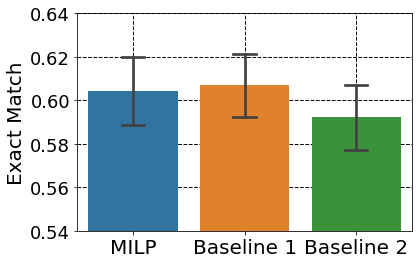

In [110]:
statistic, pvalue = stats.ttest_ind(acc2, acc_baseline2)
ax = sns.barplot(x="algo", y="accuracy", data=data, ci=95, capsize=.2)
# ax.text(.5,.87,f"p-value = {pvalue:.4f} ≮ 0.05",
#         horizontalalignment='center',
#         transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='none'))
ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("Exact Match")
# plt.title("Box plot of #candidates per cycle and system")
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 20,
          'ytick.labelsize': 18,
          'axes.titlepad': 25,
          'font.size': 24}
plt.rcParams.update(params)
plt.ylim(0.54, 0.64)
plt.savefig('plots/em.eps', bbox_inches = 'tight')
plt.show()


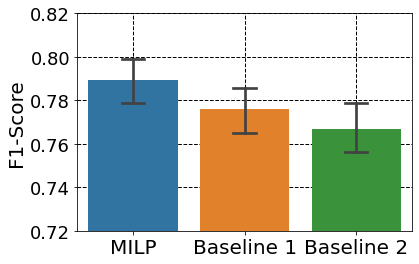

In [111]:
statistic, pvalue = stats.ttest_ind(f1_2, f1_baseline2)
ax = sns.barplot(x="algo", y="f1", data=data, ci=95, capsize=.2)
# ax.text(.5,.87,f"p-value = {pvalue:.4f} ≮ 0.05",
#         horizontalalignment='center',
#         transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='none'))
ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("F1-Score")
# plt.title("Box plot of #candidates per cycle and system")
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 20,
          'ytick.labelsize': 18,
          'axes.titlepad': 25,
          'font.size': 24}
plt.rcParams.update(params)
plt.ylim(0.72, 0.82)
plt.savefig('plots/f1_score.eps', bbox_inches = 'tight')
plt.show()


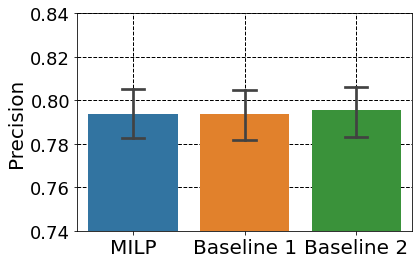

In [112]:
statistic, pvalue = stats.ttest_ind(p2, p_baseline2)
ax = sns.barplot(x="algo", y="precision", data=data, ci=95, capsize=.2)
# ax.text(.5,.87,f"p-value = {pvalue:.4f} ≮ 0.05",
#         horizontalalignment='center',
#         transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='none'))
ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)
plt.xlabel("")
plt.ylabel("Precision")
# plt.title("Box plot of #candidates per cycle and system")
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 20,
          'ytick.labelsize': 18,
          'axes.titlepad': 25,
          'font.size': 24}
plt.rcParams.update(params)
plt.ylim(0.74, 0.84)
plt.savefig('plots/precision.eps', bbox_inches = 'tight')
plt.show()


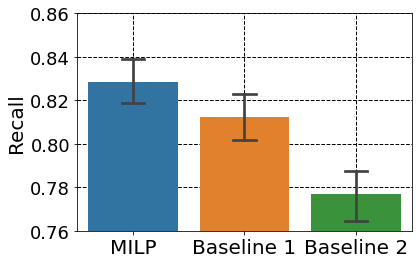

In [113]:
statistic, pvalue = stats.ttest_ind(r2, r_baseline2)
ax = sns.barplot(x="algo", y="recall", data=data, ci=95, capsize=.2)
# ax.text(.5,.87,f"p-value = {pvalue:.4f} < 0.05",
#         horizontalalignment='center',
#         transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='none'))
ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)
plt.xlabel("")
plt.ylabel("Recall")
# plt.title("Box plot of #candidates per cycle and system")
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 20,
          'ytick.labelsize': 18,
          'axes.titlepad': 25,
          'font.size': 24}
plt.rcParams.update(params)
plt.ylim(0.76, 0.86)
plt.savefig('plots/recall.eps', bbox_inches = 'tight')
plt.show()


In [32]:
len(eval_pred[0])


300

In [68]:
print(baseline(eval_pred[1]))

(-1, -1)
